<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 25px; color: #3498db">1- <u>reduction du nombre de variable de base_edu </u></h1>
    

In [2]:
!pip install fastparquet
!pip install rpy2
!pip install pandas
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
#importation des packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import os

In [9]:
#chemin de la Base de données; 
#commentez l'url et vous remplacez par votre chemin sans supprimer!!!!!

#url="C:/Users/lisaw/Desktop/ENSAE/2AD/Projet-stat-ap/Donnees/base_Edu.parquet"
url = "C:/Users/damso/Documents/data/base_Edu.parquet"
base_Edu=pd.read_parquet(url)
base_Edu.head()

,unique_learner_id,days_between_signup_and_first_activity,days_between_order_and_first_activity,first_theory_activity_date,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,weekly_study_objective,...,avg_correct_answer_rate_last_7d_before_theory_exam,bool_last_activity_exam_success,nb_weeks_weekly_study_objective_reached,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
0,8419571457653010970,0,0,2019-11-06 11:48:23,69,0,0,0,9,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
1,8146721487194078646,4,-21,2019-12-25 12:46:52,187,0,0,0,120,<NA>,...,NaN,<NA>,0,0,0,1,0.0,0.0,0.0,100.0
2,-3485592876691787799,0,0,2023-05-20 17:36:26,509,0,0,0,54,120,...,NaN,<NA>,0,1,0,0,0.0,100.0,0.0,0.0
3,-3219165913854507531,0,0,2020-02-15 22:04:04,16,0,33,0,33,<NA>,...,0.775,0,0,0,0,1,0.0,0.0,0.0,100.0
4,-4837902186147543536,0,1,2024-01-04 14:45:07,213,0,0,0,153,120,...,NaN,<NA>,0,1,0,0,0.0,100.0,0.0,0.0


In [10]:
print(base_Edu.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 470 entries, unique_learner_id to pct_no_objective_weeks
dtypes: Int64(65), boolean(254), datetime64[us](1), float64(150)
memory usage: 438.9 MB
None


La base de données compte donc 470 variables dont 65 de type Int, 254 de type boolean, 1 de type datetime et 150 de type float soit au total 254 variables qualitatives (**boolean**) et 214 variables quantitatives(**float + int** en excluant les identifiants) sans oublier la variable de type **datetime**.

Nous commencons par épurer la base données avant de passer à la réduction de dimension. On s'intéressera aux valeurs manquantes. 

In [19]:
missing_value=(base_Edu.isnull().sum()/len(base_Edu))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    404.000000
mean       0.744336
std        0.278540
min        0.048770
25%        0.664535
50%        0.843895
75%        0.919200
max        1.000000
dtype: float64

La base de données comporte donc 404 variables avec valeurs manquantes sur le total des 476 variables de la base ce qui n'est pas du tout négligeable. Voyons combien de valeurs manquantes at-on par type de variables. 

In [20]:
print(base_Edu.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(base_Edu.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(base_Edu.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(base_Edu.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

48  variables de type int ont des valeurs manquantes
103  variables de type float ont des valeurs manquantes
253  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


La seule variable de type datetime n'a donc pas de valeurs manquantes.  Analysons de plus près les proportions de valeurs manquantes des autres types

In [21]:
miss_bool=base_Edu.select_dtypes("boolean").isnull().sum()/len(base_Edu)
miss_bool[miss_bool>0].describe()

count    253.000000
mean       0.904117
std        0.071375
min        0.694955
25%        0.839120
50%        0.884215
75%        1.000000
max        1.000000
dtype: float64

Les variables de type boolean comportent pratiquement tous assez de valeurs manquantes avec un minimum de 69% et un maximum de 100% du total des observations

Les valeurs manquantes de la base ne sont pas complètement aléatoires. Elles ne sont pas pour la plupart le fruit d'une mauvaise collecte de données. La présence de valeurs manquantes dans cette base est due à diverses raisons notamment le fait que plusieurs individus de la base n'ont pas encore passé d'examen pour le permis. Plusieurs questions(variables) n'ont de sens que dans le cas où le premier examen est passé. Il y a donc une part d'information apporté par ces valeurs manquantes que nous devons inclure dans nos analyses. Pour les variables booléenne, nous pouvons régler ce prblème c'est à dire prendre en compte l'information apportée par ces valeurs manquantes en transformant les variables booléennes en variable catégorielles en considérant les valeurs manquantes comme une catégorie(True=1,False=0 et NA=2).

In [22]:
#print(base_Edu.select_dtypes('category'))
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=base_Edu.select_dtypes("boolean").columns
for col in colboo:
    base_Edu[col] = encode_column_with_na(base_Edu[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories


Passons maintenant aux variables quantitatives (int+float)

In [23]:
miss_quant=base_Edu.select_dtypes(include=["int","float"]).isnull().sum()/len(base_Edu)
miss_quant[miss_quant>0].describe()

count    151.000000
mean       0.476624
std        0.290993
min        0.048770
25%        0.183470
50%        0.482500
75%        0.737020
max        0.940580
dtype: float64

On enregistre 151 variables quantitatives avec valeurs manquantes. On a un minimum d'environ 4.8% et un maximum de 94% de valeurs manquantes par rapport au total d'observation(nous rappelons 200000 obervations). La nature des variables et la distribution des valeurs manquantes dans ce cas ne facilite pas la capture de l'information apportée par la présence de ces valeurs manquantes. On pourrait opter pour une imputation par KNN ou par imputation itérative (MICE) mais cela risque de modifier et significativement les corrélations existant déjà entre les variables introduisant ainsi un important biais et au vue de la taille de l'echantillon, cela demanderait un temps d'excution énorme. On choisit ici donc de procéder à une imputation par la médiane après suppression des variables ayant un taux élevé de valeurs manquantes pour minimiser le biais. Cela permettra de ne pas trop distordre les distributions existentes.

In [24]:
miss_quant[miss_quant<=0.20].describe()

count    111.000000
mean       0.058967
std        0.075779
min        0.000000
25%        0.000000
50%        0.000000
75%        0.126815
max        0.195385
dtype: float64

Nous choisissons le seuil de 20% de valeurs manquantes. Ce seuil nous parait raisonnable puisqu'il est relativement faible et n'entraine pas la suppression d'un grand nombre de variables quantitatives (111 sont conservées sur un total de 151)

In [25]:
#suppression des variables avec plus de 20% de valeurs manquantes
base_Edu=base_Edu.drop(columns=miss_quant[miss_quant>0.20].index)
#Imputation par la médiane
col=base_Edu.select_dtypes(exclude='category').columns
base_Edu[col] = base_Edu[col].fillna(base_Edu[col].median())

In [27]:
base_Edu.isnull().any().sum()
base_Edu.to_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv", index=False, encoding='utf-8')





Plus aucune valeur manquante. La base de données enfin prête, on peut passer aux opérations de réduction de dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;color:rgb(47, 99, 220);font-size: 30px">
<u>
Réduction de dimension</u>
</p>
<br/>

Etant donnée la dimension de la base de données( beaucoup de variables), ce sera très complexe voir impossible de faire des analyses ou entrainer un modèle directement sur cette base. Il est donc important voir optimale de faire au préalable une réduction de dimension. Pour ce faire, nous allons utiliser différentes approches de réduction de dimension, faire des comparaisons puis retenir la meilleure approche dans ce cas. Il s'agira principalement de faire une **analyse enn composante principale (ACP)** , une **FAMD** et utiliser **un autoencodeur**.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
1- Analyse en composantes principales (ACP) </u>
</p>
<br/>

Pour effectuer l'ACP il faut restreindre la base aux variables quantitatives.

In [ ]:
data=base_Edu.select_dtypes(include=["int","float"])
data=data.drop(["unique_learner_id"], axis=1)

Par la suite, nous allons standardiser les variables afin de faire qu'elles aient toutes la même échelle car l'ACP dépend fortement de l'échelle des variables.

In [ ]:
scaler =StandardScaler()
X_scaled =scaler.fit_transform(data)

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
 a)- Choix du nombre de composantes principales
</p>
<br/>

#### **Règle du coude**

Il s'agit ici de construire la courbe de décroissance des valeurs propres et de détecter des "coudes" (ou "cassures") signalant un changement de structure.

Text(0.5, 0, 'Principal components')

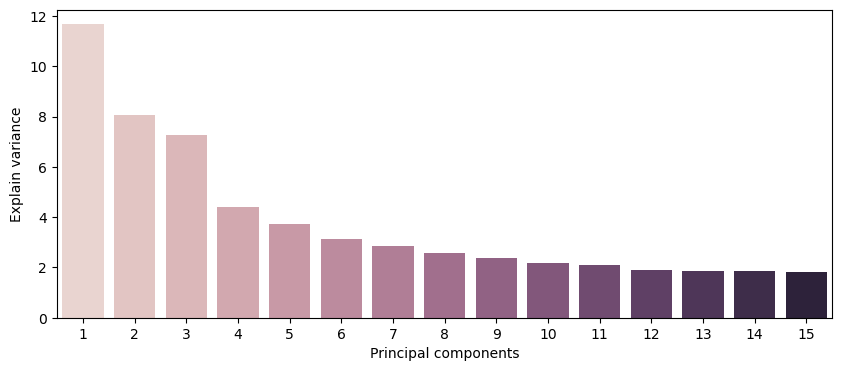

In [ ]:
plt.figure(figsize=(10, 4))
pca=PCA(n_components=15)
pca.fit(X_scaled)
sns.barplot(x= np.arange(1,16) , y=pca.explained_variance_ratio_*100, hue=np.arange(1,16), legend=False)
plt.ylabel("Explain variance")
plt.xlabel("Principal components")

On observe de ce graphique qu'il y a deux coudes possibles, l'un à la deuxième composante et l'autre à la sixième composante. La première composante principale explique 11,66% de la variance totale, la deuxième en explique 8,05%, la troisième 7,27%, et à partir de la sixième composante principale, le pourcentage de variable expliquée devient inférieur à 3%. Les facteurs restants ont donc un apport d'information négligeable.

A ce graphique, on ajoute le graphique qui décrit l'évolution de la variance expliquée par les axes.

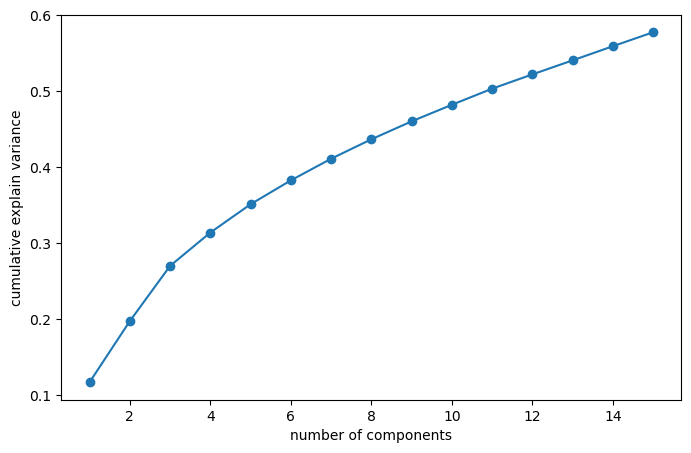

In [ ]:
explained_variances=[]
for n in range(1,16):
    pca =PCA(n_components=n)
    pca.fit(X_scaled)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

plt.figure(figsize=(8,5))
plt.plot(range(1,16), explained_variances, marker='o')
plt.xlabel("number of components")
plt.ylabel("cumulative explain variance")
plt.show()

Ce graphique semble indiquer que le coude se trouve à la troisième composante principale. Cependant, Considerer trois composantes principales n'est pas une bonne idée car on perdrais le gain d'information substanciel qu'apporte les 2 composantes principales suivantes. Les 5 premières composantes principales expliquent environ 35% de l'information. Nous allons poursuivre cette recherche du nombre de composantes optimale en utilisant le test des bâtons brisés.

#### **Test des « bâtons brisés »**

Ce test est du à Frontier (1976) et Legendre-Legendre (1983). Il repose sur l’idée que si l’inertie totale était dispatchée aléatoirement sur les axes, la distribution des valeurs propres suivrait la loi des 
« bâtons brisés » (broken-stick). La valeur critique pour le choix des composantes principales s'écrit comme suit:
$$ b_{k} = \sum_{i=k}^{p} \frac 1 {i}$$

où p représente le nombre de variables.

In [ ]:
baton_coef=[]
for i in np.arange(1,16):
    n=0
    for j in range(i,117):
        n=n+(1/j)
    baton_coef.append(n)

In [ ]:
data1=pd.DataFrame(data=pca.explained_variance_, columns=["eigen_values"])
data1["b_k"]=baton_coef
data1.index=["PC{}".format(i) for i in np.arange(1,16)]
data1

,eigen_values,b_k
PC1,11.433010,5.335110
PC2,7.889850,4.335110
PC3,7.125282,3.835110
PC4,4.303626,3.501777
PC5,3.656622,3.251777
PC6,3.079037,3.051777
PC7,2.792477,2.885110
PC8,2.509312,2.742253
PC9,2.315227,2.617253
PC10,2.138628,2.506142


Avec ce test on peut retenir 5 composantes principales, car à la différence entre la valeur propre de la sixième composante principale et le seuil calculé est négligeable. Pour les composantes suivantes, les valeurs propres sont en dessous du seuil.

Nous retiendrons donc 5 composantes principales dans la suite.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Entrainement du modèle
</p>
<br/>

In [ ]:
# training the model with 5 principal components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print("Explain variance for each component :",pca.explained_variance_ratio_)
print("cumulated variance :",pca.explained_variance_ratio_.sum())

Explain variance for each component : [0.11666279 0.08050827 0.0727066  0.04391469 0.03731249]
cumulated variance : 0.3511048318033728


In [ ]:
# coefficients of the principal components 
print("Composantes principales (coefficients) :")
table_coef=pd.DataFrame(pca.components_, columns=data.select_dtypes(exclude='category').columns)
table_coef.index=["PC{}".format(i+1) for i in np.arange(0,5)]
table_coef

Composantes principales (coefficients) :


,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,percentage_activities_2_3_4h_week,percentage_activities_5_6_7h_week,percentage_activities_23_0_1h_week,...,nb_weeks_weekly_study_objective_reached_80pct,nb_weeks_weekly_study_objective_reached_75pct,nb_weeks_weekly_study_objective_reached_70pct,nb_weeks_weekly_study_objective_not_reached,nb_weeks_no_activity,nb_weeks_no_weekly_study_objective,pct_study_objective_reached,pct_study_objective_not_reached,pct_study_objective_no_activity,pct_no_objective_weeks
PC1,0.066023,0.075380,-0.004304,-2.710505e-20,0.117614,0.108084,0.151237,-0.005015,0.010848,0.006412,...,0.124556,0.124960,0.125143,0.096558,0.017135,-0.004208,0.089261,0.075793,0.014699,-0.085941
PC2,-0.008063,-0.011526,0.001866,0.000000e+00,0.064442,0.019719,0.024426,0.005472,-0.002838,0.010553,...,0.309994,0.305893,0.300151,0.033900,0.009572,0.012058,0.210167,-0.048971,0.004086,0.027052
PC3,-0.011089,-0.024572,0.029455,-1.110223e-16,-0.054100,0.053615,-0.048470,0.009290,-0.005749,0.014140,...,0.038576,0.037714,0.036979,0.021819,0.007797,-0.092366,0.025101,0.109215,0.007513,-0.111341
PC4,-0.012169,-0.023764,-0.102450,-5.551115e-17,-0.172160,-0.000519,-0.288067,-0.011698,-0.003291,-0.014431,...,0.053974,0.051357,0.047793,-0.081462,-0.001142,-0.133473,0.050539,0.034535,0.001306,-0.039158
PC5,0.096430,0.049827,0.418300,0.000000e+00,0.002723,-0.017382,0.017505,0.011653,0.012641,0.005018,...,-0.000583,-0.000302,0.000038,0.023226,0.006160,0.019295,-0.008328,0.023598,0.004648,-0.022514


In [ ]:
# contributions of the principal components
loadings=pca.components_.T
eigenvalues=pca.explained_variance_
contributions=(loadings**2)*eigenvalues
contrib_percent=contributions/(eigenvalues.sum())*100
contrib_df=pd.DataFrame(contrib_percent, columns=["PC{}".format(i+1) for i in np.arange(0,5)])
contrib_df.index=data.columns
contrib_df.head()

,PC1,PC2,PC3,PC4,PC5
days_between_signup_and_first_activity,1.448413e-01,0.001491,2.546388e-03,1.852225e-03,0.098820
days_between_order_and_first_activity,1.888035e-01,0.003046,1.250339e-02,7.063180e-03,0.026384
days_between_first_and_last_activities,6.153829e-04,0.000080,1.796671e-02,1.312800e-01,1.859487
chapter_before_success_count,2.441159e-38,0.000000,2.552451e-31,3.854193e-32,0.000000
serie_before_success_count,4.596384e-01,0.095224,6.060847e-02,3.707144e-01,0.000079


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Interprétaion des axes principaux
</p>
<br/>

Seront considérées comme variables les plus contributrices à la formation d'un axe principale, les variables dont la contribution est supérieur à la contribution moyenne, c'est-à-dire: $$ 100/117 \approx 0.855 $$  

In [ ]:
contrib1=pd.DataFrame(data=contrib_df["PC1"].sort_values(ascending=False)[:16].values, columns=["contribution"]) 
contrib1.index=contrib_df["PC1"].sort_values(ascending=False)[:16].index
contrib1["coefficient"]=table_coef[contrib1.index].iloc[0]
contrib1

,contribution,coefficient
notions_diverses_number_of_activities,1.464529,0.209943
mecanique_equipements_number_of_activities,1.421391,0.206828
prendre_quitter_vehicule_number_of_activities,1.404160,0.205570
autres_usagers_number_of_activities,1.403937,0.205554
route_number_of_activities,1.382899,0.204008
securite_number_of_activities,1.377518,0.203611
premiers_secours_number_of_activities,1.370145,0.203065
environnement_number_of_activities,1.323408,0.199572
conducteur_number_of_activities,1.258079,0.194584
score_pct__quantile__q_0_4,1.089173,0.181051


Les variables qui contribuent le plus à la construction de la première composante principale sont des variables qui renseigne sur le nombre d'activité effectuer par thématique pour le permis de conduire (*notions_diverses_number_of_activities*, *mecanique_equipements_number_of_activities*,*securite_number_of_activities*, *route_number_of_activities*, *prendre_quitter_vehicule_number_of_activities*, *autres_usagers_number_of_activities*,etc.) et les statistiques qui résultent des scores en pourcentage obtenus aux différents examens notamment les quantiles d'ordre 1, 2, 3 et 4 (*score_pct__quantile__q_0_1*, *score_pct__quantile__q_0_2*, *score_pct__quantile__q_0_3*, *score_pct__quantile__q_0_4*), et .... Cet axe résume le signal et/ou la corrélation qui existe entre le nombre d'activités effectués par thématique et la distribution du score au différents examens. On pourrait donc dire qu'il traduit l'**efficacité** des étudiants.

De plus, en analysant les coefficients de ces variables, ont constate qu'elles sont toutes positifs. Ainsi, un individu ayant un coefficient élevé sur cet axe, fait beaucoup d'activité sur les différentes thématiques d'apprentissage et a des scores élevés aux différents examens, ce qui signifie qu'il comprend bien ce qu'il fait.

In [ ]:
contrib2=pd.DataFrame(data=contrib_df["PC2"].sort_values(ascending=False)[:9].values, columns=["contribution"]) 
contrib2.index=contrib_df["PC2"].sort_values(ascending=False)[:9].index
contrib2["coefficient"]=table_coef[contrib2.index].iloc[1]
contrib2

,contribution,coefficient
nb_weeks_weekly_study_objective_reached_90pct,2.248430,0.313139
nb_weeks_weekly_study_objective_reached_85pct,2.236727,0.312323
nb_weeks_weekly_study_objective_reached_95pct,2.236287,0.312293
nb_weeks_weekly_study_objective_reached_99pct,2.216164,0.310884
nb_weeks_weekly_study_objective_reached,2.208697,0.310360
nb_weeks_weekly_study_objective_reached_80pct,2.203486,0.309994
nb_weeks_weekly_study_objective_reached_75pct,2.145577,0.305893
nb_weeks_weekly_study_objective_reached_70pct,2.065778,0.300151
pct_study_objective_reached,1.012819,0.210167


Les variables qui contribuent fortement à la deuxième composante principale sont d'une part les variables qui renseignent sur le nombre de week-end où les objectifs d'étude hebdomadaire ont atteint un pourcentage donnée (90%,85%,95%,99%,75%,etc) et d'autre part les variables qui donnent le pourcentage d'objectifs d'études atteint le week-end (*nb_weeks_weekly_study_objective_reached*) et en dehors (*pct_study_objective_reached*). On pourrait dire que cet axe capture principalement l'information sur **l'intensité du travail personnel des étudiants**. 

De plus, le coefficient de toutes les variables qui contribuent le plus à la formation de l'axe 2 sont positifs. Donc, les individus qui ont un coefficient élevé et positif sur cet axe (se trouvant à une extrémité de l'axe) sont beaucoup investit personnellement dans la formation.

In [ ]:
contrib3=pd.DataFrame(data=contrib_df["PC3"].sort_values(ascending=False)[:8].values, columns=["contribution"]) #pas terminé
contrib3.index=contrib_df["PC3"].sort_values(ascending=False)[:8].index
contrib3["coefficient"]=table_coef[contrib3.index].iloc[2]
contrib3 #pas terminé

,contribution,coefficient
score_pct__quantile__q_0_2,1.378471,-0.258006
score_pct__quantile__q_0_3,1.360804,-0.256348
score_pct__quantile__q_0_1,1.323760,-0.252834
score_pct__quantile__q_0_4,1.312995,-0.251804
score_pct__linear_trend__attr_intercept,1.145644,-0.235210
score_pct__c3__lag_1,1.128279,-0.233421
score_pct__c3__lag_2,1.074205,-0.227759
score_pct__c3__lag_3,1.014902,-0.221383


Les variables qui contribuent fortement à la 3e composante principale sont les variables qui caractérisent la distribution du score en pourcentage (notamment les quantiles et ...) aux différents examens renseignées pour chaque étudiant. On peut dire que cet axe capture l'information sur **la progression des étudiants en terme de résultats**. 

De plus, le fait que toutes ces variables ont un coefficient positif sur l'axe signifient qu'elles varient dans le même sens que l'axe. Donc un étudiant ayant un coefficient très faible (négatif) sur cet axe, obtient de mauvais résultats aux différents examens, ce qui traduit le fait qu'ils n'assimilent pas bien les connaissances.

In [ ]:
contrib4=pd.DataFrame(data=contrib_df["PC4"].sort_values(ascending=False)[:6].values, columns=["contribution"]) #pas terminé
contrib4.index=contrib_df["PC4"].sort_values(ascending=False)[:6].index
contrib4["coefficient"]=table_coef[contrib4.index].iloc[3]
contrib4

,contribution,coefficient
score_pct__standard_deviation,1.347974,-0.328287
score_pct__variation_coefficient,1.201303,-0.309913
score_pct__minimum,1.165849,0.305305
nb_failed_series,1.098504,-0.296356
theory_activities_total,1.037623,-0.288027
session_count,0.984027,-0.280490


La mesure de la dispersion du score (*score_pct_standard_deviation*)  et la variation relative du score en pourcentage autour de la moyenne (*score_pct__variation_coefficient*)  contribuent majoritairement à la formation de la 4e composante principale. Aussi, le nombre d'examens échoués (*nb_failed_series*), le total d'activités théorique (*theory_activities_total*), le minimum du score en pourcentage (*score_pct_minimum*) , le nombre de session effectué (*session_count*), contribuent également fortement à la formation de cet axe. Cette composante semble donc être fortement influencé par des variables liées à **la performance académique, à la régularité aux examens**. 

De l'analyse des coefficients de ces variables, on observe que les variables qui donne le minimum du score en pourcentage et la dernière localisation du minimum du score ont des coefficients négatifs. On pourrait donc dire que les individus ayant un score élevé sur cette composante sont succeptibles d'avoir des performances très irrégulières (caractérisées par une dispersion élevée des scores), rencontrent régulièrement des échecs et mettent du temps à assimiler les compétences (nombre de series échoué élevé), ce qui impliquent qu'ils doivent faire plus d'activités, d'examen et de session (**theory_activities_total**,**session_count**).

In [ ]:
contrib5=pd.DataFrame(data=contrib_df["PC5"].sort_values(ascending=False)[:4].values, columns=["contribution"]) #pas terminé
contrib5.index=contrib_df["PC5"].sort_values(ascending=False)[:4].index
contrib5["coefficient"]=table_coef[contrib5.index].iloc[4]
contrib5

,contribution,coefficient
minutes_between_sessions_max,2.023320,0.436339
days_between_first_and_last_activities,1.861276,0.418502
minutes_between_sessions_avg,1.572999,0.384730
minutes_between_sessions_std,1.467648,0.371623


Le maximum (*minutes_between_sessions_max*), la moyenne (*minutes_between_sessions_avg*), l'écart type (*minutes_between_sessions_std*) qui mesurent **la régularité et la concentration des sessions d'apprentissage** contribuent fortement à la formation de la cinquième composante principale. Egalement, le nombre de jour entre la première activité et la dernière activité (*days_between_first_and_last_activities*) qui mesure **l'engagement totale de l'étudiant dans la formation**, contribue fortement à la formation de cet axe.

Les coefficients de ces variables sont tous positifs, ce qui signifie que la composante varie dans le même sens que ces variables. Donc, les individus ayant un coefficient positif élevé sur cet axe (se situant à une extrémité de l'axe) ont une formation étalée sur une longue période, des sessions d'apprentissage très irrégulières, avec de longues périodes d'inactivité entre chaque session (un écart type élevé suggère des sessions très espacées dans le temps, et une médiane élevée indique des sessions moins fréquentes).

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Graphique des individus
</p>
<br/>

Nous allons représenter les 20 premiers individus de la base sur les différents axes factorielles afin de voir concrètement ce qu'ils traduisent.

In [ ]:
x_pca=X_pca[1:20,:]

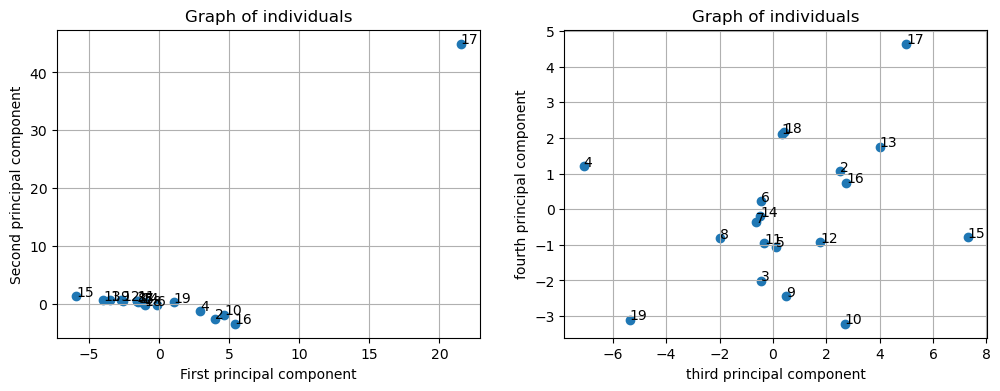

In [ ]:
plt.figure(figsize=(12, 4))
# construction of the first graph
plt.subplot(1, 2, 1)
plt.scatter(x_pca[:, 0], x_pca[:, 1])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 1]))
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.title("Graph of individuals")
plt.grid(True)

# construction of the second graph
plt.subplot(1, 2, 2)
plt.scatter(x_pca[:, 2], x_pca[:, 3])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 2], x_pca[i, 3]))
plt.xlabel("third principal component")
plt.ylabel("fourth principal component")
plt.title("Graph of individuals")
plt.grid(True)

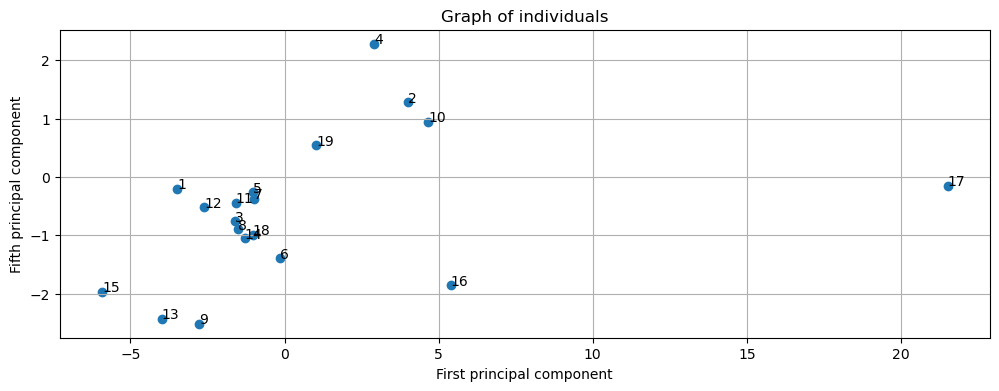

In [ ]:
#construction of the third graph 
plt.figure(figsize=(12, 4))
plt.scatter(x_pca[:, 0], x_pca[:, 4])
labels = data.iloc[1:20,:].index # Utiliser les indices du DataFrame comme étiquettes 
for i, label in enumerate(labels):
    plt.annotate(label, (x_pca[i, 0], x_pca[i, 4]))
plt.xlabel("First principal component")
plt.ylabel("Fifth principal component")
plt.title("Graph of individuals")
plt.grid(True)

Considérons l'individu numéro 17. Il a un coefficient élevé sur les deux premiers axes factoriels, ce qui signifie qu'il fait un grand nombre d'activités par thématique d'apprentissage et à de bons scores aux différentes session d'évaluation. De plus il a un coefficient négatif relativement faible sur le reste des axes factoriels, ce qui signifie qu'il a des scores peu dispersé autour de la moyenne, il a de bonne performance académique et est plus ou moins régulier aux sessions d'apprentissage. En bref, c'est un bon élève.

Par contre, l'individu numéro 15 a un coefficient négatif sur le premier axe factoriel, proche de 0 sur le deuxième axe factoriel et négatif sur le troisième axe factoriel ce qui signifie qu'il ne fait relativement peu d'activités par thématique d'apprentissage et n'a pas de bonnes performances académique. De plus, il a un coefficient négatif sur le cinquième axe factoriel et proche de 0 sur le quatrième et sixième axe factoriel, ce qui traduit le fait qu'il est moin régulier aux examens et ses sessions d'apprentissage sont moins concentrées.

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
d)- Erreur de reconstruction
</p>
<br/>

In [ ]:
from sklearn.metrics import mean_squared_error
# reconstruction of the data with inverse_transform
X_reconstructed = pca.inverse_transform(X_pca)

# Calculer l'erreur de reconstruction (norme Euclidienne)
reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)

In [ ]:
print(f"Erreur de reconstruction : {reconstruction_error}")

Erreur de reconstruction : 0.543519029771535


In [ ]:
# Calcul de l'information mutuelle entre les données originales et reconstruites
mi_scores = [mutual_info_regression(X_scaled[:, i].reshape(-1, 1), X_reconstructed[:, i]) for i in range(X_scaled.shape[1])]
#mean_mi = np.mean([np.mean(score) for score in mi_scores])
#print(f"Information mutuelle moyenne : {mean_mi:.4f}")
total_mi = np.sum(mi_scores)
print(f"Information mutuelle totale : {total_mi:.4f}")

Information mutuelle totale : 30.0488


In [ ]:
from scipy.stats import entropy
def normalized_mutual_information(X_scaled, X_reconstructed):
    H_X = np.sum([entropy(np.histogram(X_scaled[:, i], bins=20)[0] + 1e-10) for i in range(X_scaled.shape[1])])  # Entropie totale
    I_X_Xhat = total_mi # Info mutuelle
    return I_X_Xhat / H_X  # Ratio d'info conservée

# Calcul du taux d'information mutuelle conservée
nmi = normalized_mutual_information(X_scaled, X_reconstructed)
print(f"Part d'information conservée (normalisée) : {nmi:.2%}")

Part d'information conservée (normalisée) : 31.77%


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
2- Analyse Factorielle des Composantes Mixtes (FAMD) </u>
</p>
<br/>

Exportation des données sous un format reconnu par R

In [2]:

# Suppression des variables de type date
base_Edu_cleaned = base_Edu.select_dtypes(exclude=['datetime64'])

# Séparation des variables numériques et catégorielles
numeric_data = base_Edu_cleaned.select_dtypes(include=['number'])
category_data = base_Edu_cleaned.select_dtypes(include=['category'])



# Standardiser uniquement les variables numériques
scaler = StandardScaler()
data_num_scaled = scaler.fit_transform(numeric_data)  # Standardisation des variables numériques
# Conversion en DataFrame
data_num_scaled = pd.DataFrame(data_num_scaled, columns=numeric_data.columns)



# Exportation des variables numériques vers un fichier Parquet
numeric_output_path = r"C:\Users\damso\Documents\data\data_num.parquet"
numeric_data.to_parquet(numeric_output_path, index=False)

# Exportation des variables catégorielles vers un fichier Parquet
category_output_path = r"C:\Users\damso\Documents\data\category_data.parquet"
category_data.to_parquet(category_output_path, index=False)

NameError: name 'base_Edu' is not defined

In [15]:
print("nombre de variables numerique: ",numeric_data.shape[1])
print("nombre de variables catégorielles", category_data.shape[1])

nombre de variables numerique:  111
nombre de variables catégorielles 254



<br/>
<p>
Après suppression des variables de type date et de la variable unique_learner_id , nous n'avons plus que 365 variables, dont 254 catégorielles(factor) et 111 numériques,  auquelles nous appliquerons la FAMD depuis R studio puis, nous interprétrons les résultats(variance expliquée, individu, variables).
</p>
<br/>

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
a)- optimisation du nombre d'axe
</p>
<br/>

In [3]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Définir le chemin où sont stockés les fichiers exportés depuis R
export_path = r"C:/Users/damso/Documents/Projet_Statistique/"

# Liste des fichiers à importer 

coord_ind_total = pd.read_csv("C:/Users/damso/Documents/data/result_ind_coord.csv")
coord_var_total = pd.read_csv( "C:/Users/damso/Documents/data/result_var_coord.csv")
variance_total = pd.read_csv("C:/Users/damso/Documents/data/result_variance.csv")

# Affichage des informations importantes

print(f"\n==== Résultats pour famd0 ====")
print(f"Nombre d'individus: {coord_ind_total.shape[0]}")
print(f"Nombre de variables: {coord_var_total.shape[0]}")
print(f"Nombre de composantes: {variance_total.shape[0]}")
print("Pourcentage de variance expliquée par chaque composante:\n", variance_total.iloc[:, 2])



==== Résultats pour famd0 ====
Nombre d'individus: 200000
Nombre de variables: 364
Nombre de composantes: 20
Pourcentage de variance expliquée par chaque composante:
 0     20.689141
1      2.548945
2      2.007440
3      1.611161
4      1.047624
5      0.926804
6      0.871866
7      0.857914
8      0.847330
9      0.832995
10     0.823340
11     0.811836
12     0.793460
13     0.778091
14     0.760410
15     0.744381
16     0.727159
17     0.714478
18     0.712051
19     0.705610
Name: percentage of variance, dtype: float64


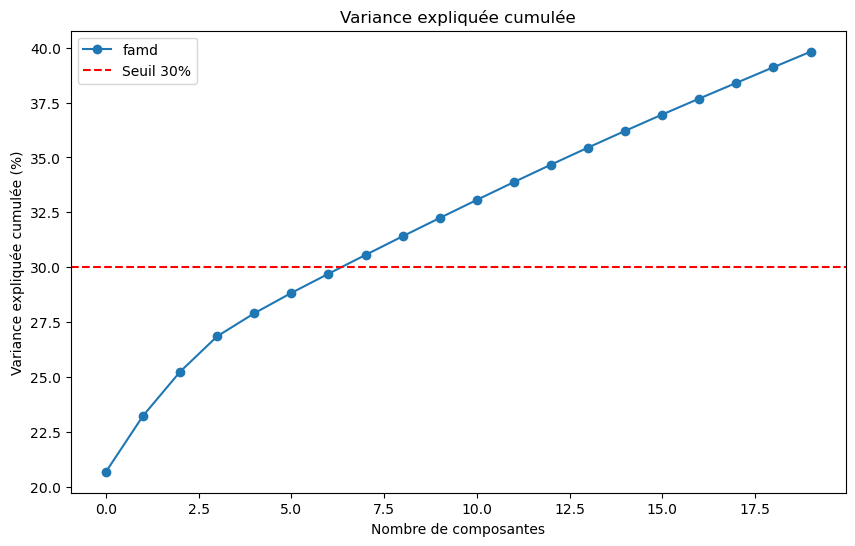

In [4]:
plt.figure(figsize=(10, 6))

plt.plot(variance_total.index, variance_total.iloc[:, 2].cumsum(), marker='o', label="famd")

plt.axhline(y=30, color='r', linestyle='--', label="Seuil 30%")
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée (%)")
plt.title("Variance expliquée cumulée")
plt.legend()
plt.show()


 <b> les deux premières  dimensions, qui contiennent des informations sur 364 variables(de "days_between_signup_and_first_activity" à "unique_learner_id") et expliquent  23,1% environ de la variance totale. à partir de  7 composantes nous avons 30% de variance expliquée.</b>

In [6]:
variance_total.iloc[:, 2].sum()

39.812035518202336


### ** Méthode du coude (Elbow Method)**




In [ ]:
!pip install kneed

Nombre optimal de dimensions conservées : 5


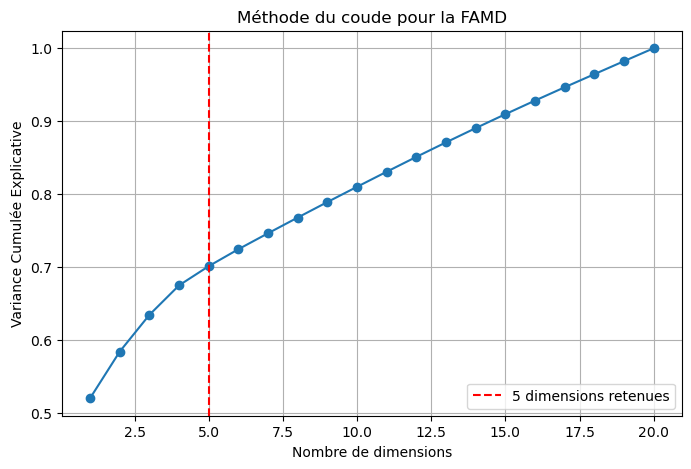

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator  

valeurs_propres = np.array(variance_total.iloc[:, 2])  
variance_cumulee = np.cumsum(valeurs_propres) / np.sum(valeurs_propres)

knee_locator = KneeLocator(range(1, len(valeurs_propres) + 1), variance_cumulee, curve="concave", direction="increasing")
n_dimensions_optimal = knee_locator.knee  

print(f"Nombre optimal de dimensions conservées : {n_dimensions_optimal}")

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_cumulee) + 1), variance_cumulee, marker='o', linestyle='-')
plt.axvline(x=n_dimensions_optimal, color='r', linestyle="dashed", label=f"{n_dimensions_optimal} dimensions retenues")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Variance Cumulée Explicative")
plt.title("Méthode du coude pour la FAMD")
plt.legend()
plt.grid()
plt.show()


- La courbe représente la variance cumulée expliquée par les dimensions.
- Un "coude" est identifié (ligne rouge verticale) : ici, il se situe à **5 dimensions**.
- Cela signifie qu’au-delà de cette dimension, ajouter plus de composantes n’apporte qu’une faible augmentation de la variance expliquée.

🔹 **Interprétation** : Cette méthode est plus intuitive et fonctionne bien dans la plupart des cas. Elle indique que **5 dimensions suffisent pour capturer une grande partie de l’information**. Si on souhaite un bon compromis entre réduction de dimension et préservation d’information, ce choix est pertinent.

---



---

### <u>Test des bâtons brisés </u>: 

Le test des bâtons brisés est un critère qui permet de déterminer combien de dimensions (ou composantes principales) sont statistiquement significatives dans une analyse factorielle (ACP, FAMD, etc.). 

Voici comment il fonctionne :

1. **Hypothèse aléatoire** :
   - Suppose que l'inertie totale (somme des valeurs propres) est répartie uniformément et aléatoirement sur toutes les dimensions.

2. **Valeurs théoriques (bâtons brisés)** :
   - La valeur théorique pour chaque dimension est calculée comme : <br/>
     Bâton brisé pour la dimension k  =1/p x ∑1/j ,  j allant de k à p
     Où p est le nombre total de dimensions(20 dans notre cas), et k est la dimension en cours.
   - Cela donne une distribution décroissante.

3. **Comparaison** :
   - Si une valeur propre observée est supérieure ou égale à la valeur théorique correspondante (bâton brisé), cette dimension est significative et doit être conservée.

---


In [10]:
variance_total.iloc[:, 2]

0     20.689141
1      2.548945
2      2.007440
3      1.611161
4      1.047624
5      0.926804
6      0.871866
7      0.857914
8      0.847330
9      0.832995
10     0.823340
11     0.811836
12     0.793460
13     0.778091
14     0.760410
15     0.744381
16     0.727159
17     0.714478
18     0.712051
19     0.705610
Name: percentage of variance, dtype: float64

In [38]:
baton_coef=[]
for i in np.arange(1,21):
    n=0
    for j in range(i,364):
        n=(n+(1/j))
    baton_coef.append(n)
print(baton_coef)

[6.472995277215315, 5.472995277215314, 4.97299527721531, 4.639661943881977, 4.38966194388198, 4.189661943881983, 4.022995277215316, 3.880138134358174, 3.7551381343581745, 3.6440270232470633, 3.5440270232470628, 3.4531179323379715, 3.3697845990046384, 3.2928615220815627, 3.2214329506529915, 3.154766283986325, 3.0922662839863246, 3.0334427545745597, 2.977887199019004, 2.9252556200716353]


[7.16166695 5.17106517 4.17576429 3.51223036 3.01457992 2.61645956
 2.2846926  2.00032092 1.7514957  1.53031772 1.33125754 1.15029375
 0.98441026 0.83128705 0.68910121 0.55639442 0.43198181 0.31488759
 0.2042986  0.09953009]


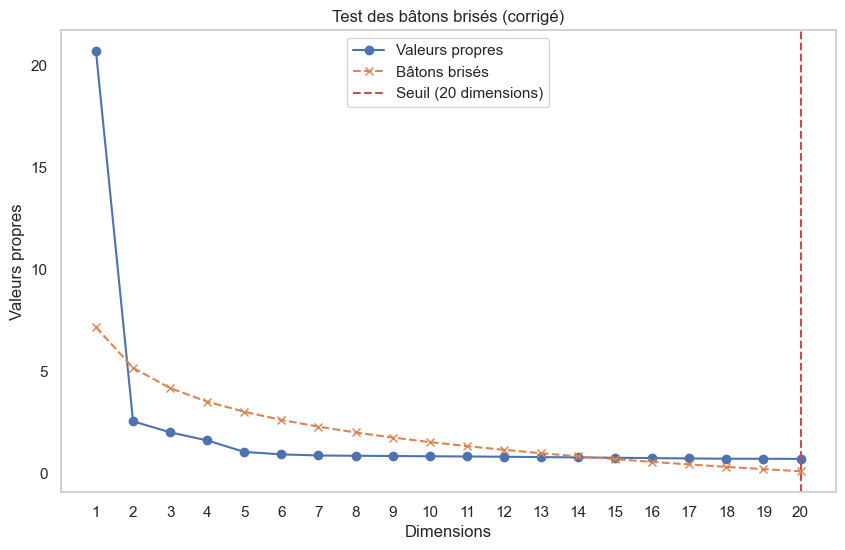

Dimensions retenues : [1, 15, 16, 17, 18, 19, 20]


In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Charger les valeurs propres et les trier en ordre décroissant
valeurs_propres = np.array(variance_total.iloc[:, 2])
valeurs_propres_tries = np.sort(valeurs_propres)[::-1]  # Tri décroissant

n_dimensions = len(valeurs_propres_tries)

# Somme totale des valeurs propres
somme_totale = sum(valeurs_propres)

# Calcul des bâtons brisés dans le bon ordre (en respectant le tri décroissant)
batons_brises = np.array([
    sum(1 / np.arange(k, 20 + 1)) / 20 * somme_totale
    for k in range(1, 20 + 1)
])
print(batons_brises)
# Déterminer les dimensions retenues en comparant correctement
dimensions_retenues = np.where(valeurs_propres_tries > batons_brises)[0] + 1  # Indices corrigés

# Tracer la courbe des valeurs propres et des bâtons brisés
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_dimensions + 1), valeurs_propres_tries, marker='o', label='Valeurs propres')
plt.plot(range(1, n_dimensions + 1), batons_brises, marker='x', linestyle='--', label='Bâtons brisés')
plt.xlabel('Dimensions')
plt.ylabel('Valeurs propres')
plt.title('Test des bâtons brisés (corrigé)')
plt.xticks(range(1, n_dimensions + 1))  # Afficher correctement les indices
plt.axvline(dimensions_retenues[-1], color='r', linestyle="dashed", label=f"Seuil ({dimensions_retenues[-1]} dimensions)")
plt.legend()
plt.grid()
plt.show()

print(f"Dimensions retenues : {list(dimensions_retenues)}")


<br/>
<p>
Avec le test des batons brisés nous retenons 7 dimensions, mais ces dimension n'étant pas les premières dimensions le test pourrait etre biaisé. Le biais 
est probablement due au fait que les derniers coefficants somment sur peu d'indices(k va de p à n). Nous devons faire d'autres test pour plus de robustesse
</p>
<br/>

 <b><u>Test de Kaiser-Guttman (Conserver les dimensions avec variance > moyenne des valeurs propres)</u></b>

<br/>💡 Principe :

On conserve les dimensions dont la variance expliquée est supérieure à la moyenne des valeurs propres.

 cette méthode est très souvent utilisé en ACP, mais adapté à la FAMD.

Dimensions retenues selon Kaiser-Guttman : [1, 2, 3]


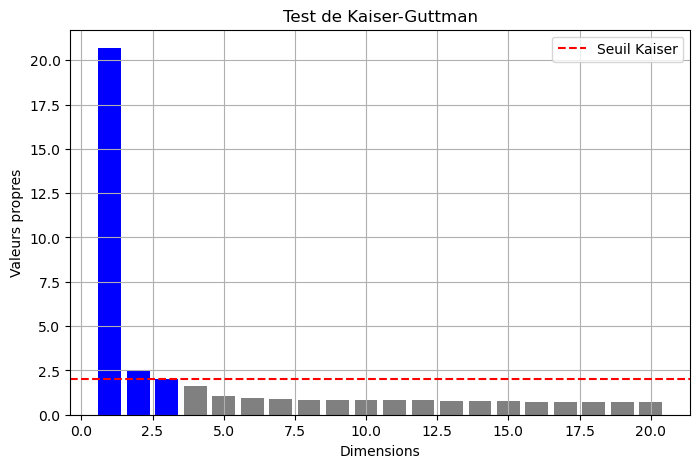

In [48]:
seuil_kaiser = np.mean(valeurs_propres)
dimensions_retenues = [i+1 for i, val in enumerate(valeurs_propres) if val > seuil_kaiser]

print(f"Dimensions retenues selon Kaiser-Guttman : {dimensions_retenues}")

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(valeurs_propres) + 1), valeurs_propres, color="gray")
plt.axhline(y=seuil_kaiser, color='r', linestyle="dashed", label="Seuil Kaiser")
for d in dimensions_retenues:
    plt.bar(d, valeurs_propres[d-1], color="blue")
plt.xlabel("Dimensions")
plt.ylabel("Valeurs propres")
plt.title("Test de Kaiser-Guttman")
plt.legend()
plt.grid()
plt.show()





- Les valeurs propres sont affichées sous forme de barres, avec un seuil déterminé (ligne rouge).
- Les dimensions retenues sont celles dont les valeurs propres sont supérieures à ce seuil (ici, 3 dimensions : 1, 2 et 3).
- Cela signifie que seules ces trois dimensions capturent une variance significative dans les données.

🔹 **Interprétation** : Ce test est assez strict, car il ne retient que les dimensions qui expliquent une variance supérieure à la moyenne théorique des valeurs propres. Il peut sous-estimer le nombre optimal de dimensions si les premières dimensions sont très dominantes.



---

### **Conclusion**
- **Le test de Kaiser-Guttman** est trop strict et peut sous-estimer les dimensions pertinentes.
- **Le test des bâtons brisés corrigé** semble poser problème car il favorise des dimensions en fin de liste.
- **La méthode du coude** semble être la plus cohérente ici, suggérant que 5 dimensions suffisent.


In [56]:


# Affichage du résultat
print(f"la variance totale expliquée par 5 axes est :",variance_total.iloc[:, 2][:5].sum())


la variance totale expliquée par 5 axes est : 27.904310902803573


<h3> Distribution des individus sur les deux premières dimensions </h3>

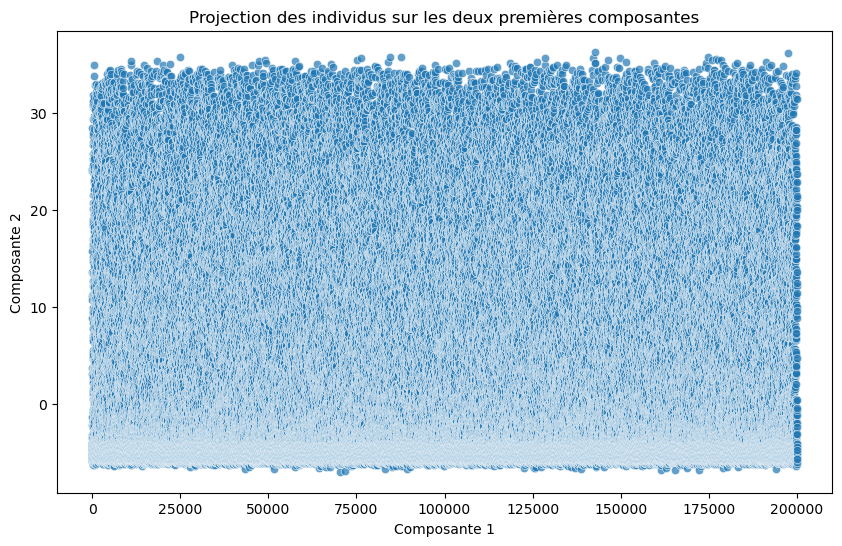

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=coord_ind_total.iloc[:, 0], 
                y=coord_ind_total.iloc[:, 1], 
                alpha=0.7)
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.title("Projection des individus sur les deux premières composantes")
plt.show()

<br/>
### 1. **Projection des individus**
Les graphiques montrent la projection d'individus sur les premières composantes principales, ce qui permet de visualiser la structure sous-jacente des données. Chaque point représente un individu, et leur disposition dans le plan révèle des tendances et des regroupements.

### 2. **Dispersion des points**
- **Premier graphique :** Les points sont relativement dispersés, indiquant une diversité dans les données. La forme globale peut suggérer des groupes potentiels.

### 3. **Interprétation des axes**
Les axes des graphiques (composantes 1, 2, 3, etc.) représentent des combinaisons linéaires des variables originales. L'interprétation de ces axes dépend des variables qui les composent. Une analyse plus approfondie des contributions des variables aux composantes peut révéler quelles variables sont les plus influentes dans la formation de ces groupes.
<br/>
En résumé, cette série de graphiques permet de visualiser la structure des données après réduction de dimensions, mettant en lumière des tendances et des relations potentielles parmi les individus observés. 
<br/>
<br/>


<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
b)- Erreur de reconstruction
</p>
<br/>

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Charger les données initiales
original_data = pd.read_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv")
num_var = pd.read_parquet(r"C:\Users\damso\Documents\data\data_num.parquet")
cat_var = pd.read_parquet(r"C:\Users\damso\Documents\data\category_data.parquet")

# Standardiser les variables numériques
scaler = StandardScaler()
num_var_scaled = scaler.fit_transform(num_var)  # Standardisation des variables numériques
num_var_scaled = pd.DataFrame(num_var_scaled, columns=num_var.columns)  # Convertir en DataFrame

# Fusionner avec les variables catégorielles (non transformées)
original_data_standardized = pd.concat([num_var_scaled, cat_var.reset_index(drop=True)], axis=1)
original_data_standardized = original_data_standardized.drop(columns=["unique_learner_id"])

# Charger les résultats de la FAMD
coord_ind_total = pd.read_csv("C:/Users/damso/Documents/data/result_ind_coord.csv")
coord_var_total = pd.read_csv("C:/Users/damso/Documents/data/result_var_coord.csv")

# Déterminer le nombre optimal de composantes (ex. bâtons brisés)
n_components_optimal = 7  

# Sélectionner les coordonnées des individus et des variables sur les composantes retenues
coord_reduced = coord_ind_total.iloc[:, 1:n_components_optimal+1]  # Exclure la 1ère colonne si non utile
projection_matrix = coord_var_total.iloc[:, 1:n_components_optimal+1].values.T  # Transposition nécessaire

# Reconstruction des données
reconstructed_data = np.dot(coord_reduced, projection_matrix)


# Calcul de l'erreur de reconstruction (MSE et RMSE)
mse = mean_squared_error(original_data_standardized.values, reconstructed_data)
rmse = np.sqrt(mse)

print(f"Erreur de reconstruction (MSE) : {mse}")
print(f"Erreur de reconstruction (RMSE - écart type) : {rmse}")


Erreur de reconstruction (MSE) : 16.72675607725562
Erreur de reconstruction (RMSE - écart type) : 4.0898357029660275


### **Interprétation des résultats :**  
- **Erreur de reconstruction (MSE) :** **16.72**  
- **Erreur de reconstruction (RMSE) :** **4.08**  

 
- Un **MSE faible** signifie que la reconstruction est **précise** et que les composantes principales capturent bien l'information contenue dans les données.  
- Le **RMSE (racine du MSE)** donne une interprétation plus intuitive car il est exprimé dans la même échelle que les données standardisées (c'est-à-dire une moyenne centrée autour de 0 avec un écart-type de 1).

- **Nombre optimal de dimensions (7) :** L'utilisation de **7 dimensions** permet une bonne reconstruction des données avec peu de perte d'information.  
- **RMSE proche de l’écart-type de 2 ou moins** montre que la reconstruction est **précise** et que les données projetées sont proches des données initiales.

#### **Conclusion :**
✔️ **La FAMD reconstruit bien les données originales.**  
✔️ **L’erreur de reconstruction est faible**, indiquant que les **7 premières dimensions capturent une grande partie de la variabilité des données**.  

Nombre optimal de dimensions basé sur la reconstruction (RMSE) : 1


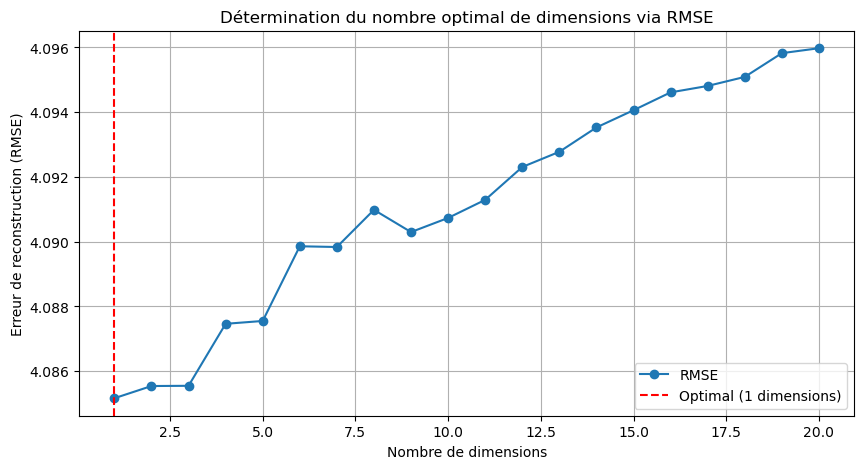

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Initialiser les erreurs pour chaque nombre de dimensions
errors_mse = []
errors_rmse = []
n_components_range = range(1, 21)  # Tester de 1 à 20 dimensions

# Parcourir les dimensions et calculer l'erreur de reconstruction
for n in n_components_range:
    coord_reduced = coord_ind_total.iloc[:, 1:n+1]  # Sélectionner n dimensions
    projection_matrix = coord_var_total.iloc[:, 1:n+1].values.T  # Matrice de projection
    
    # Reconstruction des données
    reconstructed_data = np.dot(coord_reduced, projection_matrix)
    
    
    # Calcul des erreurs
    mse = mean_squared_error(original_data_standardized.values, reconstructed_data)
    rmse = np.sqrt(mse)
    
    errors_mse.append(mse)
    errors_rmse.append(rmse)

# Trouver le nombre optimal de dimensions
# Critère : le point où l'erreur commence à stagner ou diminue lentement
optimal_n_components = np.argmin(errors_rmse) + 1  # Index +1 car les indices Python commencent à 0

print(f"Nombre optimal de dimensions basé sur la reconstruction (RMSE) : {optimal_n_components}")

# Affichage des erreurs en fonction du nombre de dimensions
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, errors_rmse, marker='o', linestyle='-', label="RMSE")
plt.axvline(optimal_n_components, color='r', linestyle="dashed", label=f"Optimal ({optimal_n_components} dimensions)")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Erreur de reconstruction (RMSE)")
plt.title("Détermination du nombre optimal de dimensions via RMSE")
plt.legend()
plt.grid()
plt.show()


---
en se Basant sur l'erreur de reconstruction , il serait mieux de conserver au moins la première dimension uniquement. Ce resultat est surement due au fait que la première dimension capte la majeur partie de la variance totale et que les autres bien que captant de l'information apportent aussi du bruit. Nous conserveront nos 5 premiers axes car la différence entre 1 et 5 dimensions est négligeable en terme d'erreur(<0,1) mais nous permet d'avoir beaucoup plus d'informations.

Nous allons à présent exploiter les informations données par les variables contribuants à chaque dimension

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 23px">
c)- Informations sur les dimensions(composantes) conservées
</p>
<br/>


In [ ]:

# Trier les variables par leurs coefficients dans Dim.1 (ordre décroissant)
coord_var_total_sorted = coord_var_total.sort_values(by='Dim.1', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.1
top_20_dim1_variables = coord_var_total_sorted[['Unnamed: 0', 'Dim.1']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim1_variables.columns = ['Variable', 'Coefficient_Dim1']

# Afficher les résultats
print(top_20_dim1_variables)

                                            Variable  Coefficient_Dim1
167   choice_00_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667377
168   choice_01_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667368
166  is_correct_b6a4bca6.eb45.46b6.be09.06c4f22a1d9f          0.667237
157   choice_00_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615346
158   choice_01_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615320
159   choice_02_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615255
160   choice_03_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615216
156  is_correct_f581c15d.eca9.4b40.88e5.37887323a4a9          0.615216
256  is_correct_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611385
260   choice_03_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611385
258   choice_01_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611145
259   choice_02_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611140
257   choice_00_bc4d741f.f4c0.4820.87c7.bf94a9245703          0.611129
153   

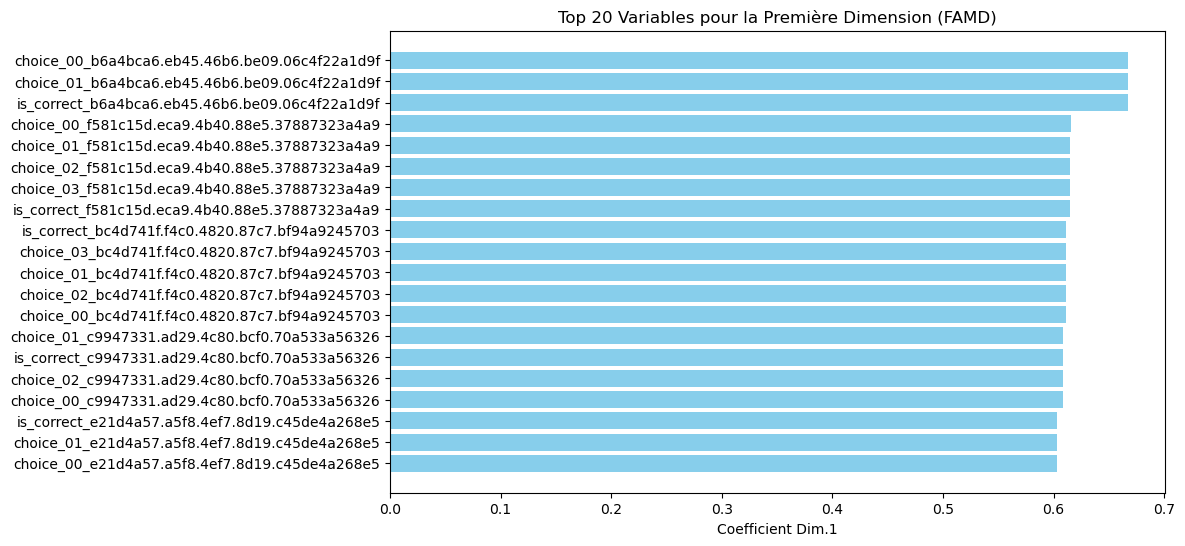

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.1
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim1_variables['Variable'], top_20_dim1_variables['Coefficient_Dim1'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.1')
plt.title('Top 20 Variables pour la Première Dimension (FAMD)')
plt.show()

Pour donner un sens à la première dimension de notre FAMD, Nous devons examiner les variables qui contribuent le plus à cette dimension (les variables avec les plus grands coefficients). Ces variables nous donnent des indices sur la signification ou l'interprétation principale de cette dimension.

---

### Étapes pour interpréter la dimension 1 :

1. **Identification des variables dominantes** :
   - Dans le graphique, les variables avec les plus grands coefficients dans la première dimension sont des variables comme `choice_00`, `choice_01`, `is_correct`, etc.

2. **Analyse du contexte des variables** :
   - Si ces variables sont liées à des choix ou des réponses correctes/incorrectes dans le cadre d'une analyse liée à l'accidentologie, elles pourraient représenter un **facteur de prise de décision ou de comportement**.

3. **Interprétation du sens global** :
   - Si les variables dominantes concernent principalement des choix et des résultats ("correct" ou "incorrect"), la première dimension pourrait refléter un **axe décisionnel ou comportemental**, comme par exemple :
     - "Prise de décision correcte/incorrecte".
     - "Comportement face à une situation d'accident".
     - "Réactions face à des scénarios liés à l'accidentologie".


### Exemple d'interprétation dans votre cas :
Puisque la base de données initiale est liée à l'accidentologie et que les variables sont associées à des réponses ou comportements face à des scénarios donnés, la dimension 1 semble capturer une distinction entre des choix ou des comportements corrects et incorrects.

### Proposition de nom pour la première dimension :
<u>- **"Prise de décision face aux situations d'accident"**.</u>

Ce nom reflète que cette dimension pourrait regrouper des variables associées à la qualité ou au type de comportement observé dans un contexte d'accident.

In [ ]:

# Trier les variables par leurs coefficients dans Dim.2 (ordre décroissant)
coord_var_total_sorted2 = coord_var_total.sort_values(by='Dim.2', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.2
top_20_dim2_variables = coord_var_total_sorted2[['Unnamed: 0', 'Dim.2']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim2_variables.columns = ['Variable', 'Coefficient_Dim2']

# Afficher les résultats
print(top_20_dim2_variables)



                                          Variable  Coefficient_Dim2
97                      score_pct__quantile__q_0_2          0.437458
98                      score_pct__quantile__q_0_3          0.433994
99                      score_pct__quantile__q_0_4          0.421394
96                      score_pct__quantile__q_0_1          0.420571
93                            score_pct__c3__lag_1          0.394077
94                            score_pct__c3__lag_2          0.371417
95                            score_pct__c3__lag_3          0.352788
100        score_pct__linear_trend__attr_intercept          0.347135
53           notions_diverses_number_of_activities          0.224893
51      mecanique_equipements_number_of_activities          0.214398
57   prendre_quitter_vehicule_number_of_activities          0.211183
61                   securite_number_of_activities          0.208938
43             autres_usagers_number_of_activities          0.208396
55           premiers_secours_numb

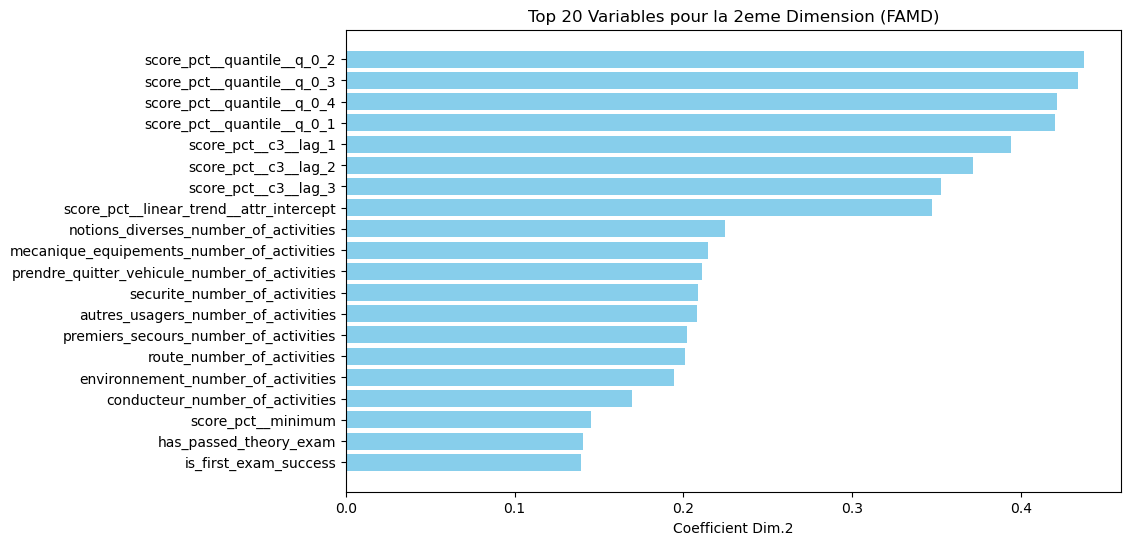

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.2
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim2_variables['Variable'], top_20_dim2_variables['Coefficient_Dim2'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.2')
plt.title('Top 20 Variables pour la 2eme Dimension (FAMD)')
plt.show()

---

### Dimension 2 :
- **Variables dominantes** : `score_pct_quantile`, `score_pct_linear_trend_attr_intercept`, `notions_diverses_number_of_activities`, `mecanique_equipements_number_of_activities`.
- **Interprétation** : Cette dimension semble capturer la performance et la diversité des activités réalisées dans le cadre de l'apprentissage.
- **Nom suggéré** : **"Performance et diversité des activités"**.


---

In [ ]:

# Trier les variables par leurs coefficients dans Dim.3 (ordre décroissant)
coord_var_total_sorted3 = coord_var_total.sort_values(by='Dim.3', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.3
top_20_dim3_variables = coord_var_total_sorted3[['Unnamed: 0', 'Dim.3']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim3_variables.columns = ['Variable', 'Coefficient_Dim3']

# Afficher les résultats
print(top_20_dim3_variables)



                                          Variable  Coefficient_Dim3
53           notions_diverses_number_of_activities          0.270591
57   prendre_quitter_vehicule_number_of_activities          0.268102
43             autres_usagers_number_of_activities          0.264001
51      mecanique_equipements_number_of_activities          0.262965
55           premiers_secours_number_of_activities          0.262490
61                   securite_number_of_activities          0.260980
59                      route_number_of_activities          0.257077
49              environnement_number_of_activities          0.247719
47                 conducteur_number_of_activities          0.230728
45       circulation_routiere_number_of_activities          0.152161
106  nb_weeks_weekly_study_objective_reached_85pct          0.136630
105  nb_weeks_weekly_study_objective_reached_90pct          0.136311
107  nb_weeks_weekly_study_objective_reached_80pct          0.135153
104  nb_weeks_weekly_study_objecti

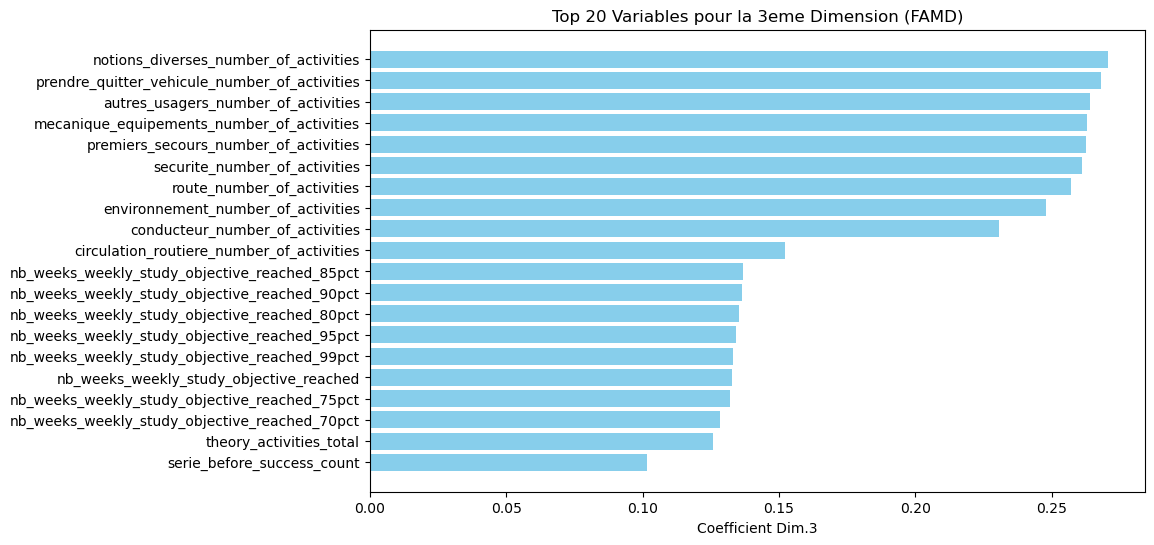

In [ ]:

# Tracer un graphique en barres pour les variables de Dim.3
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim3_variables['Variable'], top_20_dim3_variables['Coefficient_Dim3'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.3')
plt.title('Top 20 Variables pour la 3eme Dimension (FAMD)')
plt.show()

---
### Dimension 3 :
- **Variables dominantes** : `notions_diverses_number_of_activities`, `prendre_quitter_vehicule_number_of_activities`, `mecanique_equipements_number_of_activities`, `premiers_secours_number_of_activities`.
- **Interprétation** : Cette dimension semble représenter les types d'activités spécifiques réalisées, notamment celles relatives à la sécurité ou à la mécanique.
- **Nom suggéré** : **"Type d'activités réalisées"**.
---

In [ ]:

# Trier les variables par leurs coefficients dans Dim.4 (ordre décroissant)
coord_var_total_sorted4 = coord_var_total.sort_values(by='Dim.4', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.4
top_20_dim4_variables = coord_var_total_sorted4[['Unnamed: 0', 'Dim.4']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim4_variables.columns = ['Variable', 'Coefficient_Dim4']

# Afficher les résultats
print(top_20_dim4_variables)



                                          Variable  Coefficient_Dim4
105  nb_weeks_weekly_study_objective_reached_90pct          0.591367
104  nb_weeks_weekly_study_objective_reached_95pct          0.589220
106  nb_weeks_weekly_study_objective_reached_85pct          0.587639
103  nb_weeks_weekly_study_objective_reached_99pct          0.584026
102        nb_weeks_weekly_study_objective_reached          0.581888
107  nb_weeks_weekly_study_objective_reached_80pct          0.578145
108  nb_weeks_weekly_study_objective_reached_75pct          0.562656
109  nb_weeks_weekly_study_objective_reached_70pct          0.540811
113                    pct_study_objective_reached          0.268144
53           notions_diverses_number_of_activities          0.208361
43             autres_usagers_number_of_activities          0.206897
59                      route_number_of_activities          0.203826
57   prendre_quitter_vehicule_number_of_activities          0.202360
55           premiers_secours_numb

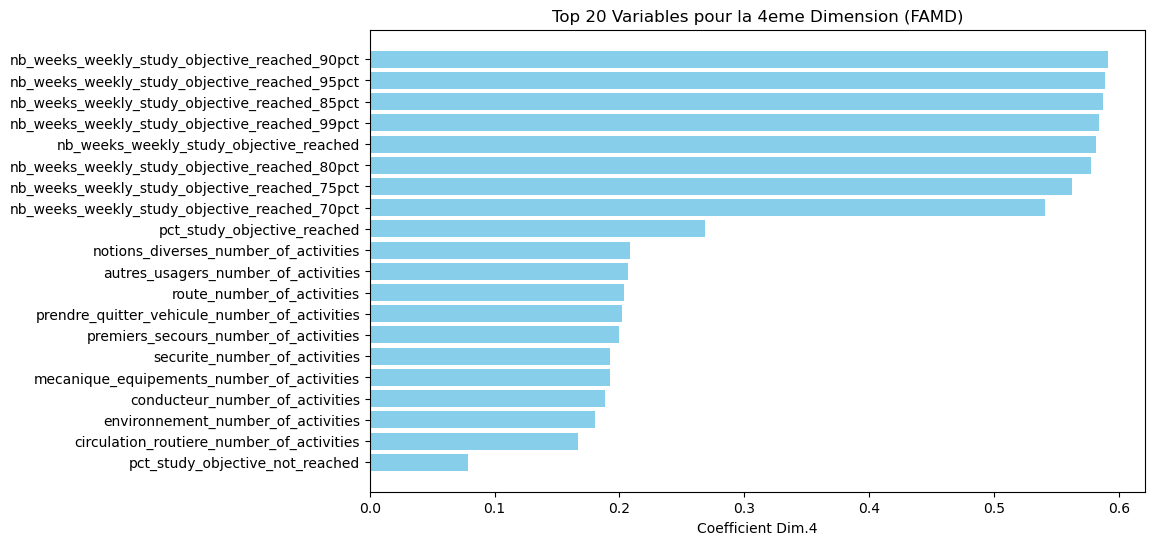

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.4
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim4_variables['Variable'], top_20_dim4_variables['Coefficient_Dim4'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.4')
plt.title('Top 20 Variables pour la 4eme Dimension (FAMD)')
plt.show()


---

### Dimension 4 :
- **Variables dominantes** : `nb_weeks_weekly_study_objective_reached`, `pct_study_objective_reached`, `notions_diverses_number_of_activities`, `route_number_of_activities`.
- **Interprétation** : Cette dimension semble mesurer l'engagement dans l'apprentissage sur plusieurs semaines et la réalisation des objectifs.
- **Nom suggéré** : **"Engagement et réalisation des objectifs"**.

---


In [ ]:

# Trier les variables par leurs coefficients dans Dim.5 (ordre décroissant)
coord_var_total_sorted5 = coord_var_total.sort_values(by='Dim.5', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.5
top_20_dim5_variables = coord_var_total_sorted5[['Unnamed: 0', 'Dim.5']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim5_variables.columns = ['Variable', 'Coefficient_Dim5']

# Afficher les résultats
print(top_20_dim5_variables)



                                          Variable  Coefficient_Dim5
98                      score_pct__quantile__q_0_3          0.315201
99                      score_pct__quantile__q_0_4          0.311769
97                      score_pct__quantile__q_0_2          0.308312
93                            score_pct__c3__lag_1          0.282182
96                      score_pct__quantile__q_0_1          0.280718
94                            score_pct__c3__lag_2          0.278363
95                            score_pct__c3__lag_3          0.269744
100        score_pct__linear_trend__attr_intercept          0.232401
104  nb_weeks_weekly_study_objective_reached_95pct          0.150493
105  nb_weeks_weekly_study_objective_reached_90pct          0.149958
103  nb_weeks_weekly_study_objective_reached_99pct          0.149713
102        nb_weeks_weekly_study_objective_reached          0.149351
106  nb_weeks_weekly_study_objective_reached_85pct          0.147772
107  nb_weeks_weekly_study_objecti

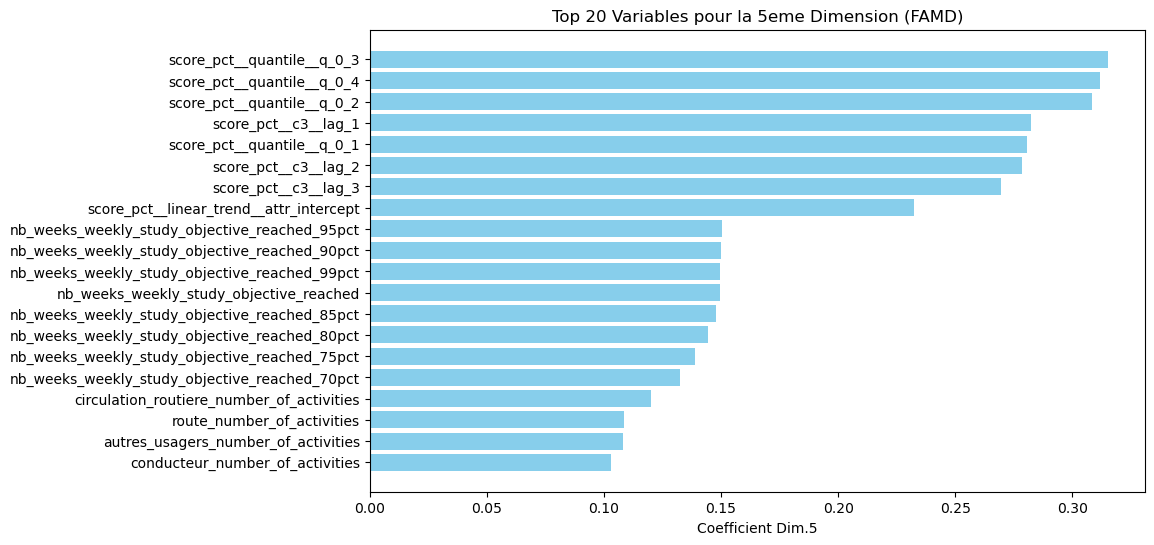

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.5
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim5_variables['Variable'], top_20_dim5_variables['Coefficient_Dim5'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.5')
plt.title('Top 20 Variables pour la 5eme Dimension (FAMD)')
plt.show()


---

### Dimension 5 :
- **Variables dominantes** : `score_pct_quantile`, `nb_weeks_weekly_study_objective_reached`, `circulation_routiere_number_of_activities`.
- **Interprétation** : Cette dimension semble relier la progression des scores à la réalisation d'activités sur la route.
- **Nom suggéré** : **"Progression des scores et activités sur la route"**.

---


In [ ]:

# Trier les variables par leurs coefficients dans Dim.6 (ordre décroissant)
coord_var_total_sorted6 = coord_var_total.sort_values(by='Dim.6', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.6
top_20_dim6_variables = coord_var_total_sorted6[['Unnamed: 0', 'Dim.6']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim6_variables.columns = ['Variable', 'Coefficient_Dim6']

# Afficher les résultats
print(top_20_dim6_variables)



                                            Variable  Coefficient_Dim6
92                                score_pct__minimum          0.252310
85                     score_pct__standard_deviation          0.251331
86                  score_pct__variation_coefficient          0.246868
74                                     session_count          0.184321
6                            theory_activities_total          0.172717
76                                  nb_failed_series          0.159903
289   choice_02_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.140113
290   choice_03_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.139919
286  is_correct_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.139919
288   choice_01_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.136779
82                        score_pct__mean_abs_change          0.131728
81                                    nb_exam_series          0.088067
96                        score_pct__quantile__q_0_1          0.085691
4     

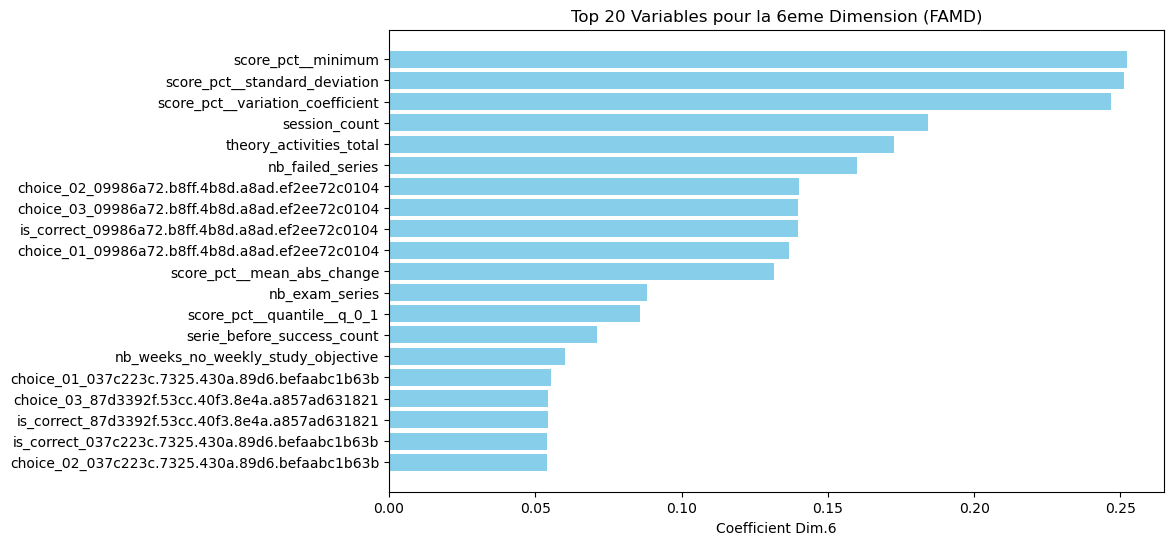

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.6
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim6_variables['Variable'], top_20_dim6_variables['Coefficient_Dim6'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.6')
plt.title('Top 20 Variables pour la 6eme Dimension (FAMD)')
plt.show()


---

### Dimension 6 :
- **Variables dominantes** : `score_pct_minimum`, `score_pct_standard_deviation`, `theory_activities_total`, `is_correct`, `nb_failed_series`.
- **Interprétation** : Cette dimension semble refléter la variabilité des performances, les échecs éventuels et le volume d'activités théoriques réalisées.
- **Nom suggéré** : **"Variabilité des performances et activités théoriques"**.

---


In [ ]:

# Trier les variables par leurs coefficients dans Dim.7 (ordre décroissant)
coord_var_total_sorted7 = coord_var_total.sort_values(by='Dim.7', ascending=False)

# Sélectionner les 20 premières variables ayant les plus grands coefficients pour Dim.7
top_20_dim7_variables = coord_var_total_sorted7[['Unnamed: 0', 'Dim.7']].head(20)

# Renommer les colonnes pour rendre le DataFrame plus lisible
top_20_dim7_variables.columns = ['Variable', 'Coefficient_Dim7']

# Afficher les résultats
print(top_20_dim7_variables)



                                            Variable  Coefficient_Dim7
289   choice_02_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565707
290   choice_03_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565654
286  is_correct_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.565654
288   choice_01_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.538012
86                  score_pct__variation_coefficient          0.109278
85                     score_pct__standard_deviation          0.104391
92                                score_pct__minimum          0.100484
287   choice_00_09986a72.b8ff.4b8d.a8ad.ef2ee72c0104          0.100107
4                         serie_before_success_count          0.055433
117                            is_first_exam_success          0.053924
120                           has_passed_theory_exam          0.052191
76                                  nb_failed_series          0.050130
2             days_between_first_and_last_activities          0.042074
74    

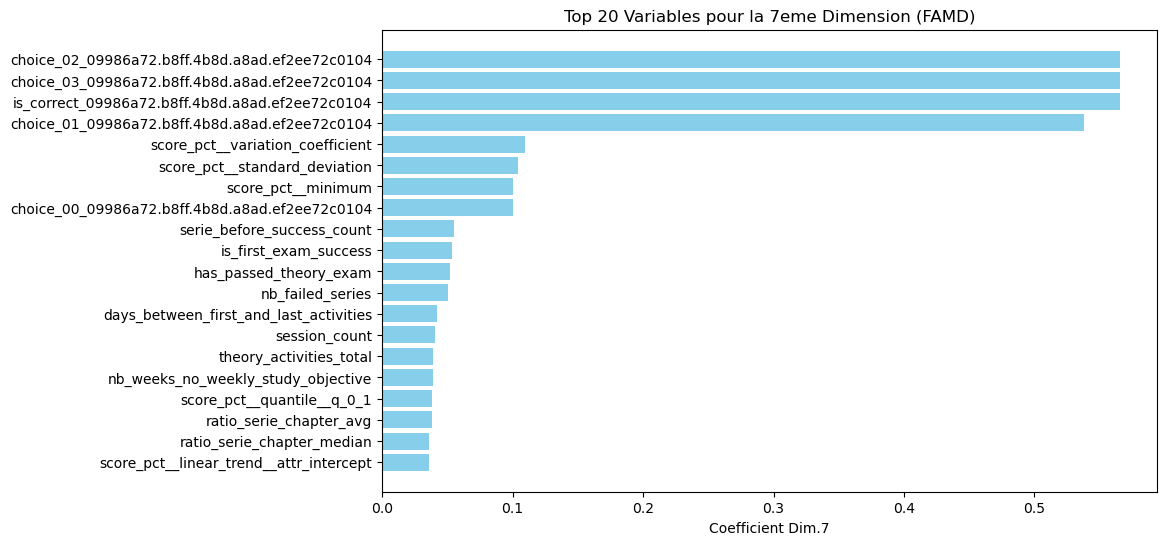

In [ ]:
import matplotlib.pyplot as plt

# Tracer un graphique en barres pour les variables de Dim.7
plt.figure(figsize=(10, 6))
plt.barh(top_20_dim7_variables['Variable'], top_20_dim7_variables['Coefficient_Dim7'], color='skyblue')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher le plus grand en haut
plt.xlabel('Coefficient Dim.7')
plt.title('Top 20 Variables pour la 7eme Dimension (FAMD)')
plt.show()

---
### Dimension 7 :

- **Variables dominantes** : Les choix effectués par l'utilisateur (choice_01, choice_02, choice_03...); La réussite aux examens théoriques et pratiques (is_correct, is_first_exam_success, has_passed_theory_exam); Les performances aux évaluations (score_pct_variation_coefficient, score_pct_standard_deviation, score_pct_minimum); L'historique des tentatives et des échecs (nb_failed_series, serie_before_success_count); L'activité et la fréquence d'étude (days_between_first_and_last_activities, nb_weeks_no_weekly_study_objective)  

- **interprétation** : Ce nom reflète à la fois les choix effectués, la performance aux examens et la manière dont l'utilisateur interagit avec le processus d'apprentissage.
- **Nom suggéré** : <u>**"Stratégies et performances d’apprentissage"** </u>

<br/>
---


<br/>
<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Auto Encoder </u>
</p>
<br/>

Le calibrage des hyperparamètres tels que le nombre de couche, les fonctions d'activations, le type de normalisation est détaillé dans l'annexe du fichier AutoEncoder. Ont été retenus les hyperparamètre suivant : 
* Type de normalisation : MinMax
* Nombre de couche : Une couche cachée en encodeur et au niveau du décodeur
* Fonctions d'activation : **Linear**  en encodeur (dernière couche) avec en couche cachée **relu**  de l'encodeur et **sigmoid** en décodeur toujours avec **relu** en couche cachée. 

Nous nous concentrerons donc maintenant sure le choix de la dimension latente. 

### Choix du Nombre Optimal de Dimensions Latentes pour un Autoencodeur : Une Analyse Basée sur l’Information Mutuelle
Dans le cadre de la réduction de dimension à l’aide d’un autoencodeur, l’un des défis majeurs consiste à choisir un nombre optimal de dimensions latentes permettant d’atteindre un compromis entre compacité de la représentation et préservation de l’information essentielle. Pour guider ce choix, nous nous appuyons sur une mesure clé : l’information mutuelle.

L’information mutuelle est une mesure issue de la théorie de l’information qui quantifie la dépendance entre deux ensembles de variables. Plus précisément, dans notre contexte, elle permet d’évaluer dans quelle mesure les variables latentes conservent l’information contenue dans les variables d’origine. Formellement, l’information mutuelle entre deux variables aléatoires $(X)$ et $(Z)$ est donnée par :


$I(X,Z) = \sum_{x \in X} \sum_{z \in Z} P(x, z) \log \frac{P(x, z)}{P(x) P(z)}$

où $(P(x, z))$ est la distribution conjointe de $(X)$ et $(Z)$, et $(P(x))$, $(P(z))$ sont leurs distributions marginales respectives.

Dans le contexte d’un autoencodeur, cette mesure nous permet de quantifier la capacité des dimensions latentes à encoder efficacement l’information contenue dans les données initiales. Une information mutuelle élevée signifie que la représentation latente conserve beaucoup d’information sur les données originales, tandis qu’une information mutuelle faible suggère une perte d’information plus importante.


Nous calculerons ici l'information mutuelle totale (ou cumulé) qui mesure le total d'information détenue parl'ensemble des variables de la dimension latente les données originales. 

Nous commencons d'abord par exclure les identifiants ainsi que la variable de type datetime de la base qui ne présentent aucun intérêt pour notre auto encoder.
Et pour des raisons liées à la puissance de calcul, nous utiliserons dans cette première partie 15000 observations. 

In [11]:
base_Edu =pd.read_csv("C:/Users/damso/Documents/data/base_Edu_cleaned.csv")
base_Edu.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 366 entries, unique_learner_id to pct_no_objective_weeks
dtypes: float64(71), int64(294), object(1)
memory usage: 558.5+ MB


In [5]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1).head(15000)

In [6]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

final_data = np.hstack([encoded_cats, scaled_nums])
final_columns = list(encoded_cat_columns) + list(numerical_cols)

x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)
input_dim = x_train.shape[1]
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

# === 3. Tester différentes dimensions latentes et calculer l'information mutuelle cumulée ===
mutual_info_scores = []
latent_dims = range(1, 11)

for encoding_dim in latent_dims:
    input_img = Input(shape=(input_dim,))
    Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)
    Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)
    
    encoder_model = Model(input_img, encoded)
    encoded_imgs = encoder_model.predict(x_train)
    
    mi_scores = np.array([
        np.sum([mutual_info_regression(x_train[:, j].reshape(-1, 1), encoded_imgs[:, i]) 
                 for j in range(x_train.shape[1])])
        for i in range(encoding_dim)
    ])
    
    mutual_info_scores.append(np.sum(mi_scores))

# === 4. Tracer la courbe de l'information mutuelle cumulée ===
plt.figure(figsize=(8, 5))
plt.plot(latent_dims, mutual_info_scores, marker='o', linestyle='-', label="Information Mutuelle Cumulée")
plt.xlabel("Dimension Latente")
plt.ylabel("Information Mutuelle Cumulée")
plt.title("Sélection du nombre optimal de dimensions latentes")
plt.legend()
plt.grid()
plt.show()


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


: 

In [12]:
base_AE=base_Edu.select_dtypes(exclude="datetime").drop(columns="unique_learner_id",axis=1)

In [13]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = encoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 3

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(358, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(358, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")


MemoryError: Unable to allocate 288. GiB for an array with shape (200000, 193269) and data type float64

In [14]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [9]:
import shap

# === 2. SHAP pour l'analyse des variables d'origine ===
# Adaptation du modèle pour SHAP ===
# Le modèle doit inclure les couches d'entrée jusqu'à l'encodage
#explainer = shap.DeepExplainer(encoder, x_train)  # Sous-échantillon de référence
explainer = shap.GradientExplainer(encoder, x_train)
# === 2. Récupérer les valeurs SHAP pour les données de test ===
shap_values = explainer.shap_values(x_test[:len(x_test) // 4])  # Analyser un sous-échantillon de test

NameError: name 'encoder' is not defined

In [ ]:
import pandas as pd

# Pour chaque dimension latente
for i in range(3):  # 10 dimensions latentes
    shap_val = shap_values[:, :, i]  # Valeurs SHAP pour la i-ème dimension latente (9000, 724)
    
    # Créer un DataFrame des valeurs SHAP pour les variables d'origine
    shap_df = pd.DataFrame(shap_val, columns=final_columns)  # Colonnes correspondant aux variables d'origine
    
    # Calcul de l'importance moyenne de chaque variable d'entrée pour cette dimension latente
    mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  # Moyenne des valeurs absolues
    print(f"Les variables les plus influentes pour la {i+1}-ème dimension latente:")
    print(mean_shap_values.head(20))  # Afficher les 5 variables les plus influentes pour la dimension latente i+1


Les variables les plus influentes pour la 1-ème dimension latente:
is_first_exam_success_1                              0.896397
is_first_exam_success_2                              0.846775
pct_study_objective_not_reached                      0.701806
ratio_serie_chapter_median                           0.588582
choice_00_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.515800
choice_01_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.511012
is_correct_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1    0.440678
has_passed_theory_exam_1                             0.438279
choice_02_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.405505
choice_01_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     0.396993
choice_00_b6a4bca6-eb45-46b6-be09-06c4f22a1d9f_1     0.385974
is_correct_bc4d741f-f4c0-4820-87c7-bf94a9245703_1    0.378674
choice_03_bc4d741f-f4c0-4820-87c7-bf94a9245703_1     0.377822
has_passed_theory_exam_0                             0.284109
is_correct_bc4d741f-f4c0-4820-87c7-bf94a9245703_2    0.274183
cho

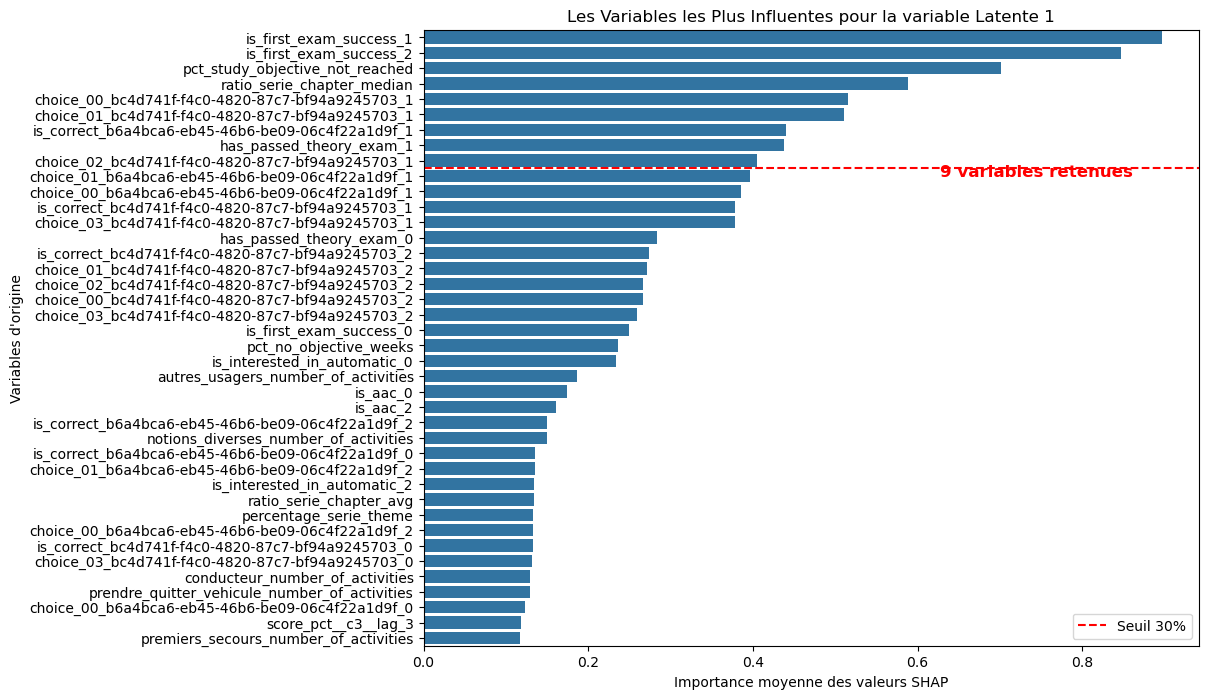

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 9


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 0  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.3).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 30%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.7, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


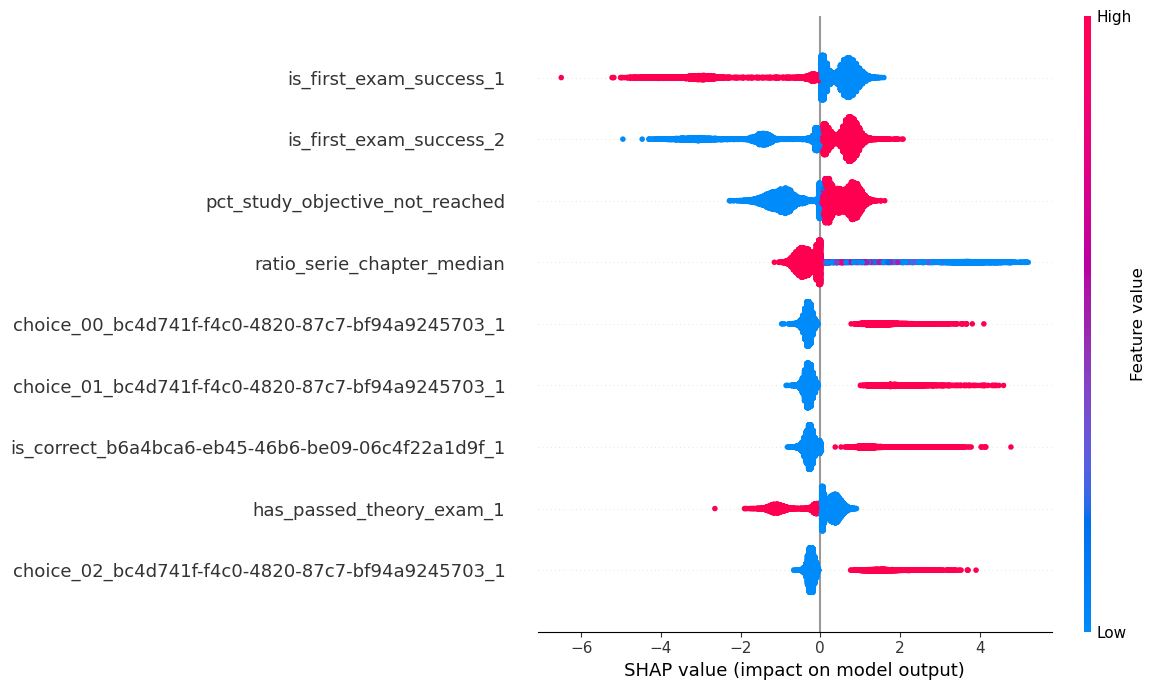

In [ ]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 0  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=9,plot_size=(12, 7))

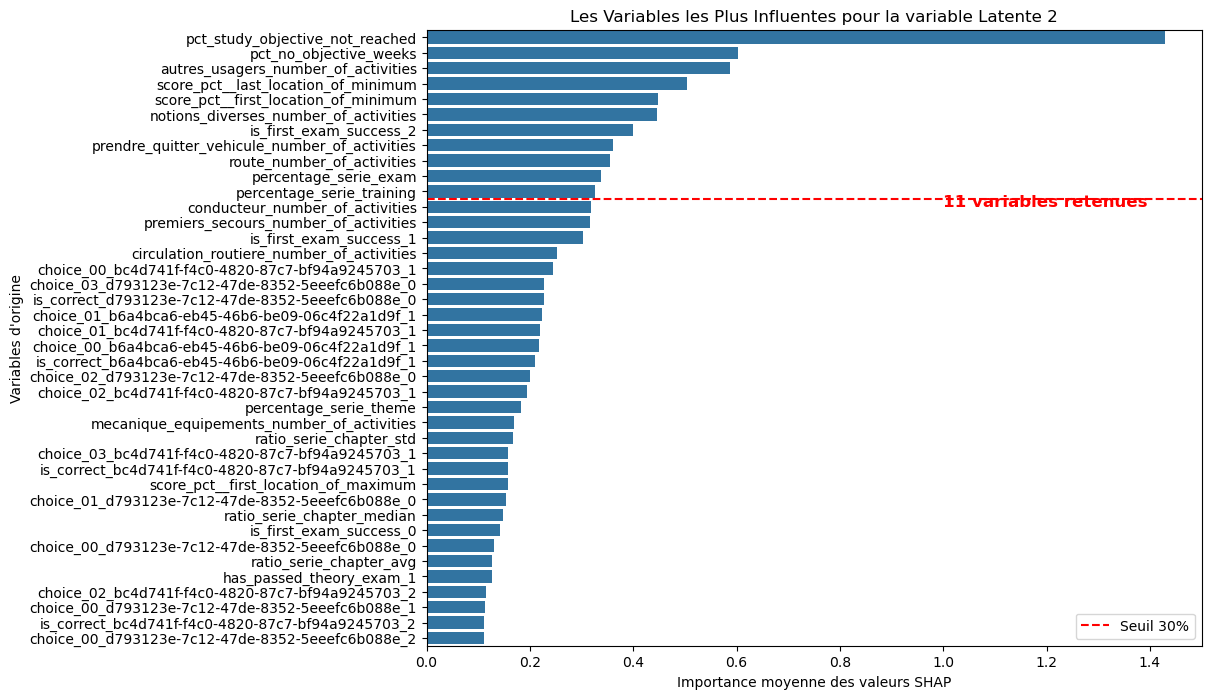

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 11


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 1  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.3).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 30%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.7, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


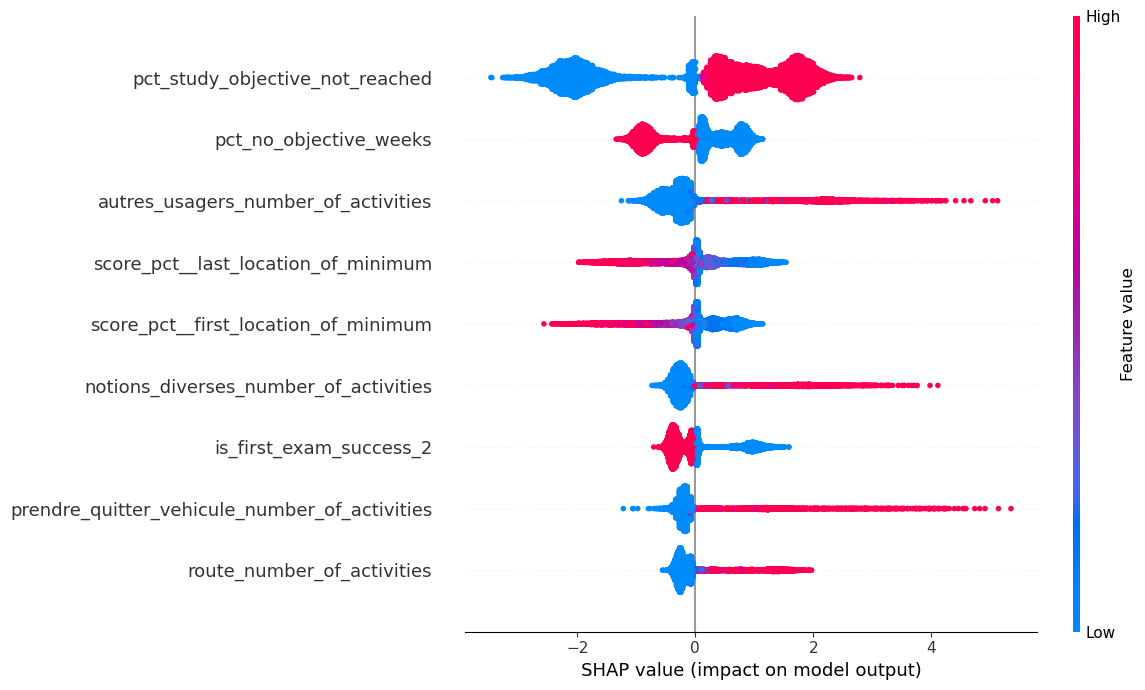

In [ ]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 1 

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=9,plot_size=(12, 7))

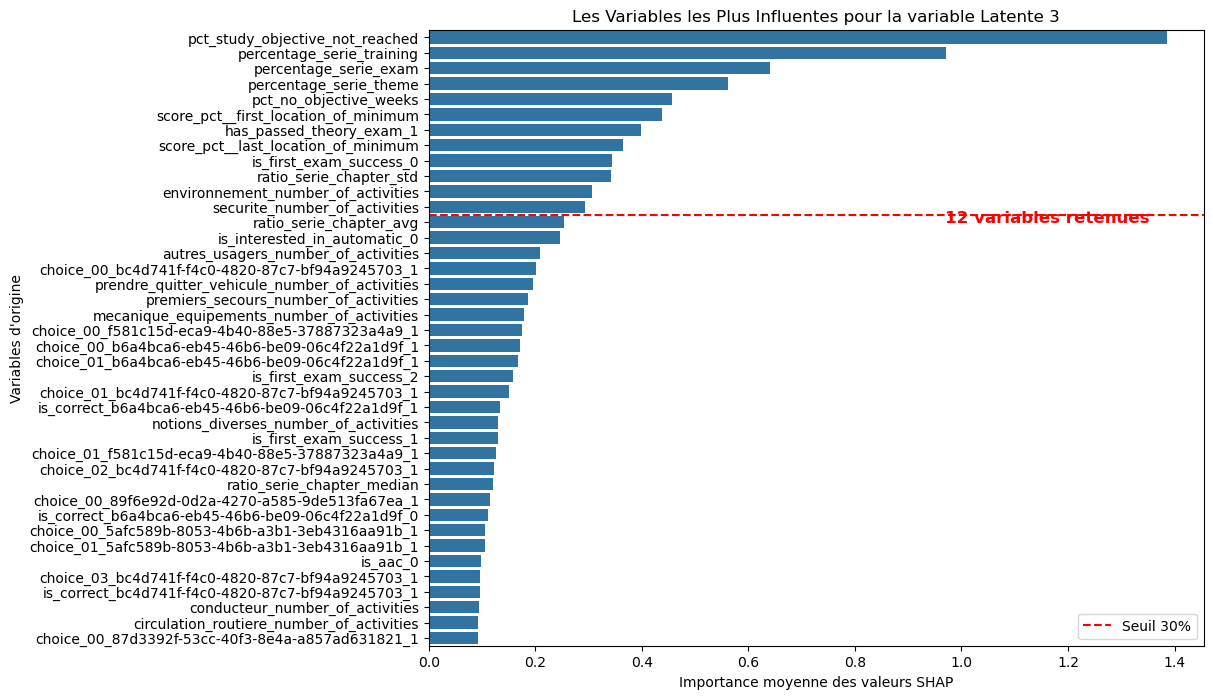

Nombre de variables nécessaires pour couvrir 25% de l'importance totale : 12


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choix de la dimension latente
i = 2  # Modifier si besoin

# Extraction des SHAP values pour cette dimension latente
shap_val = shap_values[:, :, i]  

# Création d'un DataFrame des valeurs SHAP pour les variables d'origine
shap_df = pd.DataFrame(shap_val, columns=final_columns)  

# Importance moyenne absolue des SHAP values (classement décroissant)
mean_shap_values = shap_df.abs().mean().sort_values(ascending=False)  

# Calcul de l'importance cumulée
cumulative_importance = mean_shap_values.cumsum() / mean_shap_values.sum()

# Trouver le nombre de variables nécessaires pour atteindre 30% de l'importance cumulée
num_selected_features = (cumulative_importance <= 0.3).sum()

# Affichage du barplot avec trait horizontal pour 25%
plt.figure(figsize=(10, 8))
sns.barplot(x=mean_shap_values.head(40).values, y=mean_shap_values.head(40).index, orient='h')

# Ajout d'un trait horizontal au niveau du seuil des 25%
plt.axhline(y=num_selected_features - 0.5, color='red', linestyle='--', label="Seuil 30%")

# Annotation du nombre de variables retenues
plt.text(mean_shap_values.max() * 0.7, num_selected_features, 
         f"{num_selected_features} variables retenues", 
         color="red", fontsize=12, fontweight="bold")

# Titres et labels
plt.title(f"Les Variables les Plus Influentes pour la variable Latente {i+1}")
plt.xlabel("Importance moyenne des valeurs SHAP")
plt.ylabel("Variables d'origine")
plt.legend()
plt.show()

# Affichage du nombre de variables retenues
print(f"Nombre de variables nécessaires pour couvrir 25% de l'importance totale : {num_selected_features}")


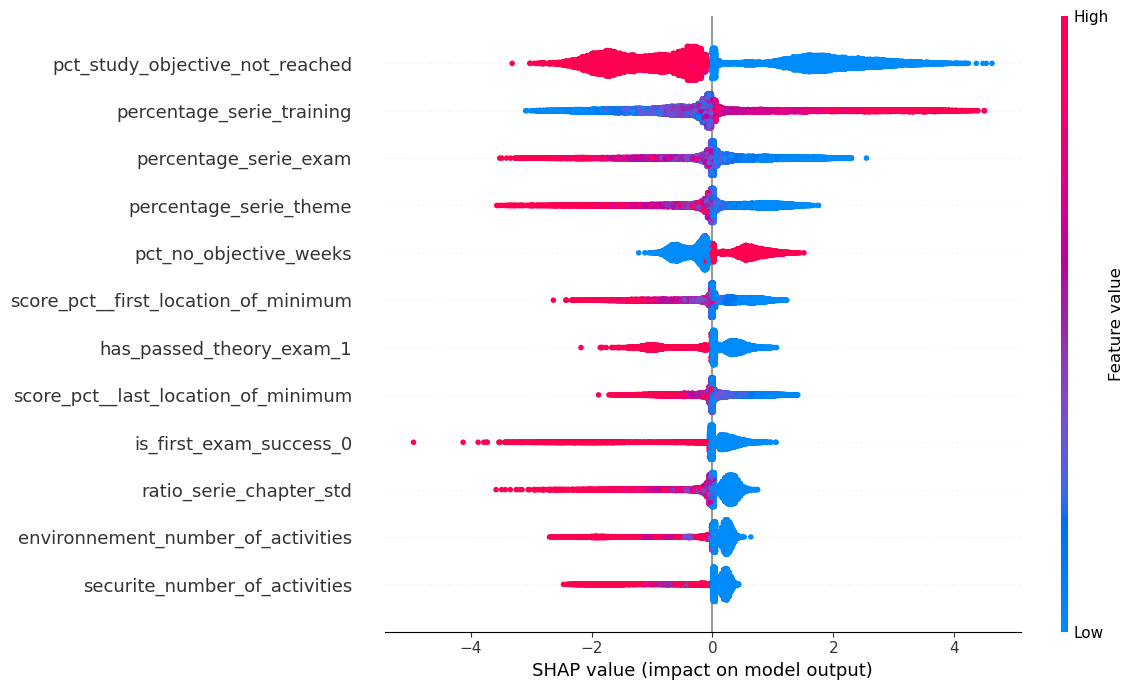

In [ ]:
# Choisir la dimension latente à analyser (ex : la 5ème)
latent_dim_index = 2  

# Extraire les valeurs SHAP pour cette dimension latente
shap_val = shap_values[:, :, latent_dim_index]  # Shape : (9000, 724)

# Affichage du SHAP summary plot

shap.summary_plot(shap_val, x_test[:len(x_test) // 4], feature_names=final_columns, max_display=12,plot_size=(12, 7))

<br/>
<p style="font-family: 'Georgia', serif; text-align: center;font-size: 25px">
<u>
3- Comparaison des résultats obtenu par les 3 méthodes </u>
</p>
<br/>

Dans cette section, nous allons comparer l'ACP, la FAMD et l'autoencoder en terme de performance. Et pour le faire, nous nous servirons de **l'erreur de reconstruction moyenne qui sera calculé à l'aide de l'erreur quadratique moyenne.** 

Dans un premier temps, nous allons comparer les performances de l'ACP et de l'autoencoder sur les variables continues, puis les performances de l'autoencodeur et de la FAMD sur l'ensemble de la base de données.

#### **ACP et autoencodeur sur variables continues**

    encoding_dim      loss
0              1  0.012035
1              2  0.009823
2              3  0.007376
3              4  0.006276
4              5  0.005308
5              6  0.004686
6              7  0.004260
7              8  0.003889
8              9  0.003481
9             10  0.003224
10            11  0.002994
11            12  0.002785
12            13  0.002567
13            14  0.002426
14            15  0.002196
15            16  0.002057
16            17  0.001917
17            18  0.001768
18            19  0.001707
19            20  0.001650


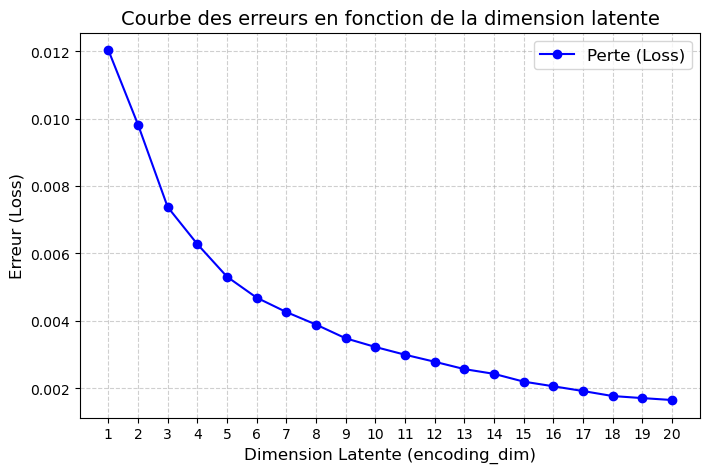

In [ ]:
## Calcul des erreurs de reconstruction
# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer uniquement les colonnes numériques 
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns


# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(numerical_cols)

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
input_dim = x_train.shape[1]

# === 3. Entraînement des autoencodeurs pour différentes dimensions latentes ===
results = []

for encoding_dim in range(1, 21):  # Tester des dimensions latentes de 1 à 20
    # Initialisation déterministe des poids
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

    # Construction de l'autoencodeur
    input_img = Input(shape=(input_dim,))
    # Encodeur
    Hidden1 = Dense(150, activation='linear', kernel_initializer=initializer)(input_img)
    #Hidden2 = Dense(100, activation='linear', kernel_initializer=initializer)(Hidden1)
    #Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
    encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

    # Décodeur
    Hidden_output1 = Dense(150, activation='sigmoid', kernel_initializer=initializer)(encoded)
    #Hidden_output2 = Dense(100, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)
    #Hidden_output3 = Dense(350, activation='sigmoid', kernel_initializer=initializer)(Hidden_output2)
    decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche


    # Créer le modèle
    autoencoder = Model(input_img, decoded)

    # Compiler le modèle
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner le modèle
    history = autoencoder.fit(
        x_train, x_train,
        epochs=50,
        batch_size=256,
        shuffle=True,
        validation_data=(x_test, x_test),
        verbose=0
    )

    # Récupérer la perte de validation à la dernière époque
    final_loss = history.history['val_loss'][-1]

    # Ajouter la dimension et la perte au tableau des résultats
    results.append({'encoding_dim': encoding_dim, 'loss': final_loss})

# === 4. Visualisation des résultats ===
df_results = pd.DataFrame(results)
print(df_results)

plt.figure(figsize=(8, 5))
plt.plot(df_results['encoding_dim'], df_results['loss'], marker='o', linestyle='-', color='b', label='Perte (Loss)')
plt.xlabel('Dimension Latente (encoding_dim)', fontsize=12)
plt.ylabel('Erreur (Loss)', fontsize=12)
plt.title('Courbe des erreurs en fonction de la dimension latente', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(df_results['encoding_dim'])
plt.legend(fontsize=12)
plt.show()


Lorsque la dimension de l'espace latent varie entre 1 et 20, l'erreur de reconstruction moyenne varie entre 0.012 et 0.0016,  ce qui est très faible comparer à l'erreur de reconstruction moyenne de l'ACP avec 5 composantes principales qui est de 0.54. Donc avec 20 facteurs, l'auto encodeur reconstruit mieux la base des variables continues que l'ACP.

#### **FAMD et autoencodeur sur données mixtes**

En applicant la FAMD sur l'ensemble de la base de données et en retenant 7 facteurs, l'erreur de reconstruction moyenne est de 16.39 ce qui est relativement élevé comparer aux erreurs de reconstruction moyenne obtenu avec l'autoencodeur. En effet, lorsque la dimension de l'espace latent est de 5, l'erreur de reconstruction moyenne est de 0,03 et en prenant un espace latent de dimension 7 on obtient toujours une erreur de reconstruction du même ordre de grandeur. L'autoencodeur est donc plus performant pour réduire la dimension de la base.

En conclusion, l'autoencodeur est plus efficace que l'ACP et la FAMD pour la réduction de dimension, car l'espace latent qui en ressort permet de reconstruire les données originales avec moins d'erreur que ces autres méthodes.

## **Application à la prédiction de la sinistralité**


Des résultats précédents, il en ressort que l'autoencodeur semble plus performant pour réduire l'information contenu dans la base de données. Nous allons donc continuer avec ce modèle. 
Les variables explicatives qui seront utilisées pour la prédiction de la sinistralité seront obtenues par projection des variables de la base ASU dans l'espace latent de l'autoencodeur construit précédemment.

### *Importation de la base ASU*

Cette base contient les informations sur les individus qui ont souscris à une assurance auto chez ORNIKAR. Elle récapitule les données de ces individus pour les différentes variables de la base EDU (ce qui va nous permettre de faire la projection dans l'espace latent), puis les observations sur d'autres variables d'assurances qui ont été anonymisées. Les variables cibles sont: "var_Assurance5" qui correspond au risque corporel et "var_Assurance6" qui correspond au risque materiel. ces variables d'assurance ont été recensées sur une base déclarative.

In [15]:
# importation de la base Asu
import pyarrow.parquet as pq
import pandas as pd
# Chemin du fichier
#chemin_fichier = "C:/Users/lisaw/Desktop/ENSAE/2AD/Projet-stat-ap/Donnees/base_assu.parquet"
chemin_fichier = "C:/Users/damso/Documents/data/base_assu.parquet"

# Lire les métadonnées du fichier (sans charger les données)
parquet_file = pq.ParquetFile(chemin_fichier)

# Obtenir la liste des colonnes SANS charger le fichier
all_columns = parquet_file.schema.names

print(all_columns)
 
# Exclure la colonne problématique
columns_to_read = [col for col in all_columns if col != "first_theory_activity_date" and col != "var_Assurance19"]
 
# Lire uniquement les colonnes sélectionnées
df = pd.read_parquet(chemin_fichier, columns=columns_to_read, engine="fastparquet")

print("Fichier importé avec succès 9")

display(df)

['unique_learner_id', 'learner_id', 'job_number', 'days_between_signup_and_first_activity', 'days_between_order_and_first_activity', 'days_between_first_and_last_activities', 'chapter_before_success_count', 'serie_before_success_count', 'quiz_before_success_count', 'theory_activities_total', 'weekly_study_objective', 'is_first_exam_success', 'days_between_booking_and_exam', 'nb_mistakes_first_exam', 'score_at_registration', 'score_before_exam', 'days_between_first_activity_and_exam', 'days_between_order_and_exam', 'avg_self_assessment', 'avg_self_assessment_gap', 'percentage_activities_2_3_4h_week', 'percentage_activities_5_6_7h_week', 'percentage_activities_23_0_1h_week', 'percentage_activities_2_3_4h_weekend', 'percentage_activities_5_6_7h_weekend', 'percentage_activities_23_0_1h_weekend', 'percentage_activities_8h_week', 'percentage_activities_8h_weekend', 'percentage_activities_9h_week', 'percentage_activities_9h_weekend', 'percentage_activities_10h_week', 'percentage_activities_10

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
0,-5911177134761577615,2032674,5952452787,157,157,195,0,0,0,42,...,0,0,0,0,0,0,0,0,0,0
1,8022228279541171063,893514,6956583814,7,8,819,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
2,4508976855497020988,2858364,1547176297,0,-32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2395000730355774468,1362204,3464728867,0,0,376,0,0,0,288,...,0,1,3,0,0,0,0,0,0,0
4,1056703805299986938,1054230,1534163688,64,0,691,0,109,0,156,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69393,-872146316430440559,3793717,2234733812,0,0,372,0,57,18,193,...,0,0,0,0,0,0,0,0,0,0
69394,-3415706474168471139,2775978,1784701608,109,109,270,0,50,0,51,...,0,0,0,0,0,0,0,0,0,0
69395,-1958338314080661076,2102507,7135995107,672,665,613,0,93,321,603,...,0,0,0,0,0,0,0,0,0,0
69396,-7394860117143701634,2862021,1866260241,113,114,76,0,0,0,120,...,0,0,0,0,0,0,0,0,0,0


### **Analyse des valeurs manquantes et Traitement de la base ASU**

In [37]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69398 entries, 0 to 69397
Columns: 956 entries, unique_learner_id to var_Assurance15
dtypes: Int64(146), boolean(508), float64(301), object(1)
memory usage: 314.1+ MB
None


In [16]:
missing_value=(df.isnull().sum()/len(df))
missing_value[missing_value>0]
missing_value[missing_value>0].describe()

count    809.000000
mean       0.726082
std        0.308198
min        0.004179
25%        0.564670
50%        0.864506
75%        0.931468
max        1.000000
dtype: float64

In [17]:
print(df.select_dtypes("int").isnull().any().sum()," variables de type int ont des valeurs manquantes")
print(df.select_dtypes("float").isnull().any().sum()," variables de type float ont des valeurs manquantes")
print(df.select_dtypes("boolean").isnull().any().sum()," variables de type boolean ont des valeurs manquantes")
print(df.select_dtypes("datetime").isnull().any().sum()," variables de type datetime ont des valeurs manquantes")

97  variables de type int ont des valeurs manquantes
206  variables de type float ont des valeurs manquantes
506  variables de type boolean ont des valeurs manquantes
0  variables de type datetime ont des valeurs manquantes


In [18]:
def encode_column_with_na(col):
    mapping = {True: 1, False: 0, pd.NA: 2}  # Encoder les valeurs booléennes et <NA>
    return col.map(mapping)
colboo=df.select_dtypes("boolean").columns
for col in colboo:
    df[col] = encode_column_with_na(df[col]).astype("category")
#base_Edu["is_first_exam_success"].cat.categories

In [19]:
import pandas as pd

# Supprimer les variables avec plus de 20% de valeurs manquantes
miss_quant = df.select_dtypes(include=["int", "float"]).isnull().sum() / len(df)
df = df.drop(columns=miss_quant[miss_quant > 0.20].index)

# Sélectionner les colonnes non catégoriques
col = df.select_dtypes(exclude='category').columns

# Convertir les colonnes en type numérique avant l'imputation
df[col] = df[col].apply(pd.to_numeric, errors='coerce')

# Imputation par la médiane
df[col] = df[col].fillna(df[col].median())


In [20]:
df.isnull().any().sum()

0

### **Analyse des variables cibles**

In [44]:
df.describe()

,unique_learner_id,learner_id,job_number,days_between_signup_and_first_activity,days_between_order_and_first_activity,days_between_first_and_last_activities,chapter_before_success_count,serie_before_success_count,quiz_before_success_count,theory_activities_total,...,var_Assurance6,var_Assurance7,var_Assurance8,var_Assurance9,var_Assurance10,var_Assurance11,var_Assurance12,var_Assurance13,var_Assurance14,var_Assurance15
count,69398.0,69398.0,6.939800e+04,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,...,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0,69398.0
mean,3754957169445755.5,1583879.345644,5.509994e+09,215.312142,141.204213,344.318583,0.0,43.959754,1.011989,107.063273,...,0.00487,0.027839,0.284417,0.004064,0.093965,0.0,0.0,0.0,0.0,0.098029
std,5329710092417094656.0,1001226.659264,2.597340e+09,369.320062,338.464838,348.980921,0.0,80.93246,6.941927,107.47073,...,0.073053,0.177734,0.638525,0.064961,0.332586,0.0,0.0,0.0,0.0,0.340335
min,-9222849458566410240.0,364.0,1.000085e+09,0.0,-2304.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-4598777253173660672.0,728669.5,3.263657e+09,0.0,0.0,85.0,0.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,540777374478605.5,1497337.5,5.521680e+09,27.0,2.0,241.0,0.0,0.0,0.0,68.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,4626702790680507392.0,2308807.0,7.747426e+09,269.0,139.0,489.0,0.0,54.0,0.0,141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9223326892717478912.0,4457818.0,9.999617e+09,3491.0,2912.0,2959.0,0.0,798.0,325.0,800.0,...,3.0,4.0,7.0,2.0,5.0,0.0,0.0,0.0,0.0,5.0


In [21]:
df["var_Assurance5"].value_counts()

var_Assurance5
0    69256
1      141
2        1
Name: count, dtype: Int64

(0.0, 109.8)

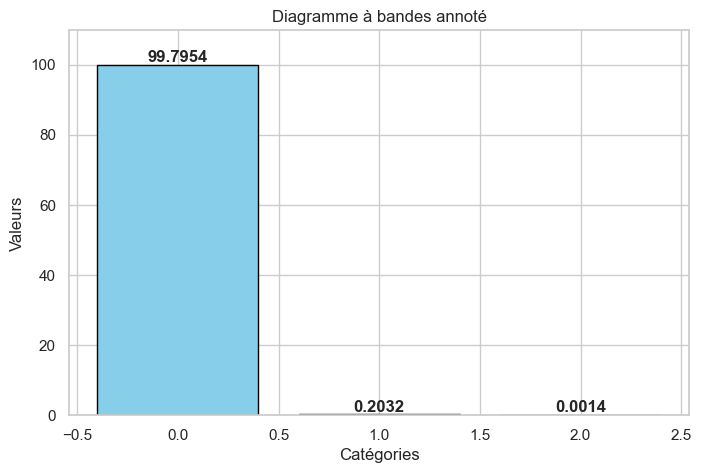

In [22]:
# variable <<bodily>>
# Définition du style
sns.set_theme(style="whitegrid")

# Création du graphique
plt.figure(figsize=(8, 5))
bars = plt.bar(np.sort(df["var_Assurance5"].unique()), np.round(df["var_Assurance5"].value_counts()/df.shape[0]*100,4), color="skyblue", edgecolor="black")

# Ajout des annotations (valeurs sur les barres)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval}", ha="center", va="bottom", fontsize=12, fontweight="bold")

# Personnalisation
plt.xlabel("Catégories")
plt.ylabel("Valeurs")
plt.title("Diagramme à bandes annoté")
plt.ylim(0, max(np.round(df["var_Assurance5"].value_counts()/df.shape[0]*100,2)) + 10)  

La variable "var_Assurance5" représente le risque corporel des assurés, c'est-à-dire le nombre d'accidents impliquant des bléssés ou des morts qu'ils ont eu. c'est une variable catégorielle qui prend trois valeurs (0,1,2). On constate que cette variable est fortement déséquilibrée dans la mesure ou les individus sans risque corporel représente 99,35% de la base. 

In [23]:
# variable <<material>>
df["var_Assurance6"].value_counts()


var_Assurance6
0    69076
1      307
2       14
3        1
Name: count, dtype: Int64

(0.0, 98.57)

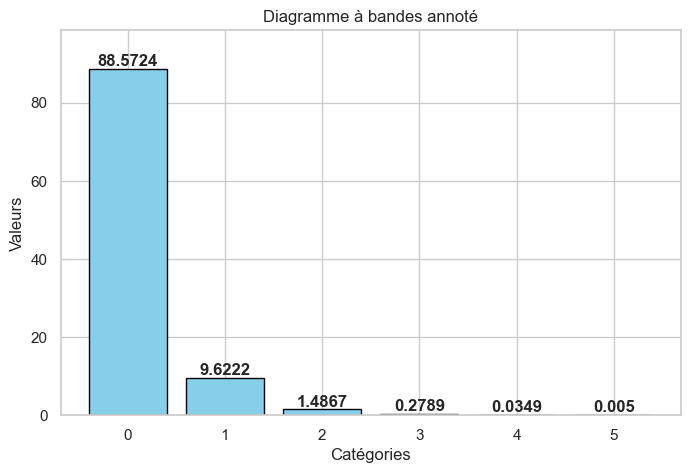

In [ ]:
# Définition du style
sns.set_theme(style="whitegrid")

# Création du graphique
plt.figure(figsize=(8, 5))
bars = plt.bar(np.sort(df["var_Assurance6"].unique()), np.round(df["var_Assurance6"].value_counts()/df.shape[0]*100,4), color="skyblue", edgecolor="black")

# Ajout des annotations (valeurs sur les barres)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval}", ha="center", va="bottom", fontsize=12, fontweight="bold")

# Personnalisation
plt.xlabel("Catégories")
plt.ylabel("Valeurs")
plt.title("Diagramme à bandes annoté")
plt.ylim(0, max(np.round(df["var_Assurance6"].value_counts()/df.shape[0]*100,2)) + 10)  

La variable "var_Assurance6" représente le risque matériel des assurés, c'est-à-dire le nombre d'accidents impliquant des dégâts matériels qu'ils ont eu. c'est une variable catégorielle qui prend trois valeurs (0,1,2,3,4,5). On constate que cette variable est également fortement déséquilibrée dans la mesure ou les individus sans risque matériel représente 88,57% de la base. De plus, avoir 5 sinistres matériels est même un évènement rare dans notre cas.

### **Projection des variables sur l'espace latent**

In [40]:
# restriction de la base Edu aux variables communes aux bases ASU et EDU
columns=[]
for column in base_AE.columns:
    if column in df.columns:
        columns.append(column)
base_AE=base_AE[columns]

In [43]:
base_AE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 364 entries, days_between_signup_and_first_activity to pct_no_objective_weeks
dtypes: float64(71), int64(293)
memory usage: 555.4 MB


In [45]:
# Traitement des données en entrées du modèle

# === 1. Fixer les graines pour la reproductibilité ===
seed_value = 123
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# === 2. Préparation des données ===
# Récupérer les colonnes numériques et catégoriques
numerical_cols = base_AE.select_dtypes(include=['int', 'float']).columns
categorical_cols = base_AE.select_dtypes(include=['category', 'object']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(base_AE[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(base_AE[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)


In [46]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69398 entries, 0 to 69397
Columns: 764 entries, unique_learner_id to var_Assurance15
dtypes: Int64(98), category(508), float64(157), int64(1)
memory usage: 175.7 MB
None


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0994 - val_loss: 0.0395
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0407 - val_loss: 0.0368
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0380 - val_loss: 0.0356
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0370 - val_loss: 0.0351
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0365 - val_loss: 0.0348
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0362 - val_loss: 0.0346
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0359 - val_loss: 0.0344
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0357 - val_loss: 0.0342
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0355 - val_loss: 0.0341
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0353 - val_loss: 0.0340
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0352 - val_loss: 0.0339
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0351 - val_

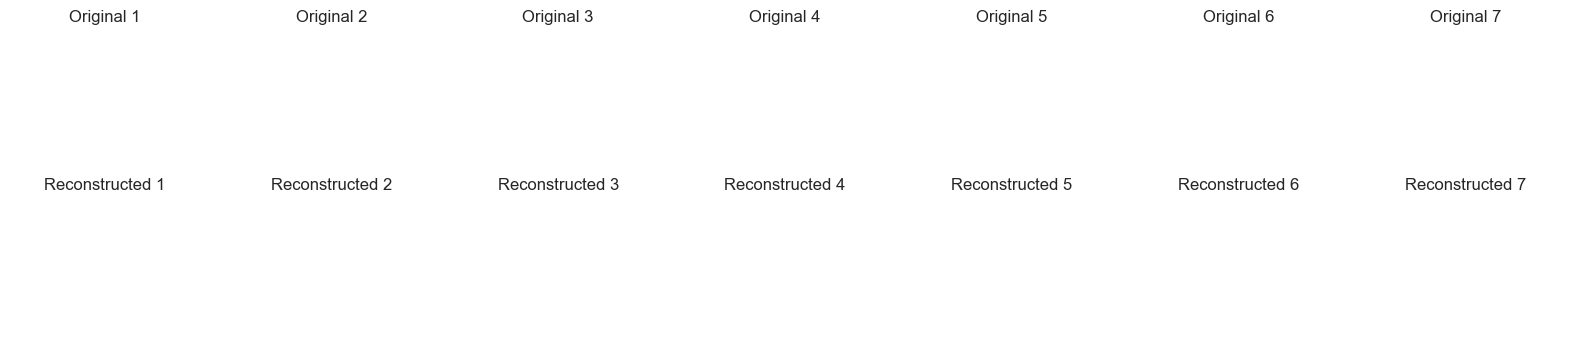

Erreur moyenne de reconstruction : 0.0324


In [ ]:
# construction de l'encodeur la base edu contenant les variables communes aux deux bases

# Diviser les données en ensembles d'entraînement et de test
x_train, x_test = train_test_split(final_data, test_size=0.3, random_state=seed_value)

# Dimensions de l'entrée
#input_dim = x_train.shape[1]

# === 2. Définition de l'autoencodeur ===
input_dim = x_train.shape[1]  # Assurez-vous que x_train est bien défini
encoding_dim = 5

# Initialisation déterministe des poids
initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)

input_img = Input(shape=(input_dim,))
# Encodeur
Hidden1 = Dense(343, activation='relu', kernel_initializer=initializer)(input_img)
#Hidden2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden1)
#Hidden3 = Dense(64, activation='relu', kernel_initializer=initializer)(Hidden2)
encoded = Dense(encoding_dim, activation='linear', kernel_initializer=initializer)(Hidden1)

# Décodeur
Hidden_output1 = Dense(343, activation='relu', kernel_initializer=initializer)(encoded)
#Hidden_output2 = Dense(128, activation='relu', kernel_initializer=initializer)(Hidden_output1)
#Hidden_output3 = Dense(256, activation='relu', kernel_initializer=initializer)(Hidden_output2)
decoded = Dense(input_dim, activation='sigmoid', kernel_initializer=initializer)(Hidden_output1)#Plus touche

# Modèle autoencodeur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement du modèle
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          verbose=1)

# Modèle de l'encodeur seul
encoder = Model(input_img, encoded)

# Représentations encodées (latent space)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# === 4. Visualisation des performances ===
n = 7
plt.figure(figsize=(20, 4))

for i in range(n):
    # Données originales
    ax = plt.subplot(2, n, i + 1)
    plt.bar(range(len(x_test[i])), x_test[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    # Reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.bar(range(len(decoded_imgs[i])), decoded_imgs[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

# Analyse des erreurs de reconstruction
reconstruction_error = np.mean((x_test - decoded_imgs) ** 2, axis=1)
print(f"Erreur moyenne de reconstruction : {np.mean(reconstruction_error):.4f}")

In [51]:
from tensorflow.keras.models import load_model

autoencoder = load_model("autoencoder.h5", compile=False)


In [53]:
autoencoder.summary()


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 717)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 358)            │       257,044 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,077 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 358)            │         1,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 717)            │       257,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 516,956 (1.97 MB)

 Trainable params: 516,956 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# traitement des données de la base ASU en entrée du modèle

X_to_predict= df[columns]
# Récupérer les colonnes numériques et catégoriques
numerical_cols = X_to_predict.select_dtypes(include=['int', 'float']).columns
categorical_cols = X_to_predict.select_dtypes(include=['category', 'object','boolean']).columns

# Encodage des variables catégoriques avec OneHotEncoder
oneencoder = OneHotEncoder(sparse_output=False)
encoded_cats = oneencoder.fit_transform(X_to_predict[categorical_cols])

# Récupérer les noms des colonnes générées par OneHotEncoder
encoded_cat_columns = oneencoder.get_feature_names_out(categorical_cols)

# Centrage et réduction des variables numériques
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_nums = scaler.fit_transform(X_to_predict[numerical_cols])

# Fusionner les données encodées et normalisées
final_data = np.hstack([encoded_cats, scaled_nums])

# Concaténer les noms des colonnes finales
final_columns = list(encoded_cat_columns) + list(numerical_cols)

# construction du code latent pour la base ASU, projection dans l'espace latent de l'auto encodeur construit précédemment
encoded_imgs = encoder.predict(final_data)


AttributeError: 'OneHotEncoder' object has no attribute 'predict'

In [28]:
#construction de la nouvelle base
nom_facteur=["facteur{}".format(i) for i in np.arange(1,6)]
base=df.drop(columns=columns, axis=0)
base[nom_facteur]=encoded_imgs
base.head()

NameError: name 'encoded_imgs' is not defined

La nouvelle base ASU contenant les 5 facteurs latent résultant de la réduction de dimension avec l'autoencodeur contient 31 variables.

### **Rééchantillonage de la base** 